Descompresion de datos

In [49]:
import missingno as msno
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from unidecode import unidecode
from pandas.api.types import CategoricalDtype
import geopandas

In [50]:
def iqr(x):
    """Función para calcular el Rango Intercuartílico."""
    return x.quantile(0.75) - x.quantile(0.25)

def mode(x):
    """Función para obtener la moda (el primer valor si hay múltiples)."""
    return x.mode().iloc[0] if not x.mode().empty else np.nan

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    limpio = unidecode(texto)
    limpio = re.sub(r'[\s-]+', '_', limpio)
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


In [51]:
df_bases = pd.read_fwf(
    'datos/estaciones_smn.txt', 
    skiprows=2, 
    header=None, 
    encoding='latin-1'
)

nombres_columnas = [
    'nombre_original', 'provincia', 'lat_gr', 'lat_min',
    'lon_gr', 'lon_min', 'altura', 'nro', 'oaci'
]

df_bases.columns = nombres_columnas

df_bases['nombre_original'] = df_bases['nombre_original'].str.strip()
df_bases['provincia'] = df_bases['provincia'].str.strip()

df_bases['latitud'] = df_bases['lat_gr'] + np.sign(df_bases['lat_gr']) * (df_bases['lat_min'] / 60)
df_bases['longitud'] = df_bases['lon_gr'] + np.sign(df_bases['lon_gr']) * (df_bases['lon_min'] / 60)

df_bases = df_bases.drop(columns=['lat_gr', 'lat_min', 'lon_gr', 'lon_min'])

df_bases.head()


,nombre_original,provincia,altura,nro,oaci,latitud,longitud
0,BASE BELGRANO II,ANTARTIDA,256.0,89034.0,SAYB,-77.866667,-34.616667
1,BASE CARLINI (EX JUBANY),ANTARTIDA,11.0,89053.0,SAYJ,-62.233333,-58.650000
2,BASE ESPERANZA,ANTARTIDA,24.0,88963.0,SAYE,-63.383333,-56.983333
3,BASE MARAMBIO,ANTARTIDA,198.0,89055.0,SAWB,-64.233333,-56.616667
4,BASE ORCADAS,ANTARTIDA,12.0,88968.0,SAYO,-60.733333,-44.733333


In [52]:
nombres_originales_df_bases=df_bases['nombre_original'].unique()

In [53]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")
        

df = pd.read_excel(ruta_completa, header=header_row_index)
df_largo = df.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# Renombrar las variables a un formato limpio (sin espacios ni símbolos)
mapa_nombres = {
    'Temperatura (°C)': 'temperatura_c',
    'Temperatura máxima (°C)': 'temperatura_maxima_c',
    'Temperatura mínima (°C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitación (mm)': 'precipitacion_mm',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
estaciones_df_final=df_largo['Estación'].unique()
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])
df_largo['Estación'] = df_largo['Estación'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)
df_bases['Estación'] = df_bases['nombre_original'].apply(limpiar_texto)
df_bases = df_bases.drop(columns=['nombre_original'])
# Procesamiento de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')


# --- Creación del DataFrame Final ---
columnas_ordenadas = ['Estación', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# Crear el tipo de dato Categórico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)

correcciones_estaciones = {
    'coronel_pringles_aero': 'coronel_pringles_aero',
    'el_trebol': 'el_trebol',
    'presidencia_roque_saenz_pena_aero': 'presidencia_roque_saenz_pena_a', 
    'san_miguel': 'san_miguel',
}

df_final['Estación'] = df_final['Estación'].map(correcciones_estaciones).fillna(df_final['Estación'])
df_enriquecido = pd.merge(
    left=df_final,
    right=df_bases, 
    on='Estación',
    how='left'
)

mapa_regiones = {
    'jujuy': 'NOA',
    'salta': 'NOA',
    'formosa': 'NEA',
    'misiones': 'NEA',
    'tucuman': 'NOA',
    'santiago del es': 'NOA',
    'chaco': 'NEA',
    'corrientes': 'NEA',
    'catamarca': 'NOA',
    'la rioja': 'NOA',
    'cordoba': 'Pampeana',
    'santa fe': 'Pampeana',
    'san juan': 'Cuyo',
    'entre rios': 'NEA',
    'mendoza': 'Cuyo',
    'san luis': 'Cuyo',
    'la pampa': 'Pampeana',
    'buenos aires': 'Pampeana',
    'capital federal': 'Pampeana',
    'neuquen': 'Patagonia',
    'rio negro': 'Patagonia',
    'chubut': 'Patagonia',
    'santa cruz': 'Patagonia',
    'tierra del fueg': 'Patagonia', 
    'antartida': 'Antártida'
}
# Limpiamos la columna 'provincia' y creamos la columna 'region'
df_enriquecido['region'] = df_enriquecido['provincia'].str.lower().map(mapa_regiones)
df_enriquecido.to_csv('datos/dataframe_enriquecido.csv', index=False)


¡Encabezado detectado en la fila (0-indexada): 4!


In [54]:
estaciones_final_limpias = set(df_final['Estación'].unique())
estaciones_bases_limpias = set(df_bases['Estación'].unique())

no_coinciden_en_final = sorted(list(estaciones_final_limpias - estaciones_bases_limpias))
no_coinciden_en_bases = sorted(list(estaciones_bases_limpias - estaciones_final_limpias))

print("\n---")
print("Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):")
if no_coinciden_en_final:
    for nombre in no_coinciden_en_final:
        print(f"- {nombre}")
else:
    print("¡Todos los nombres limpios de df_final['Estación'] se encuentran en df_bases['Estación']!")

print("\n---")
print("Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):")
if no_coinciden_en_bases:
    for nombre in no_coinciden_en_bases:
        print(f"- {nombre}")
else:
    print("¡Todos los nombres limpios de df_bases['Estación'] se encuentran en df_final['Estación']!")
print("---")


---
Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):
- coronel_pringles_aero
- el_trebol
- san_miguel

---
Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):
- benito_juarez
- campo_de_mayo_aero
- chapelco_aero
- chepes
- ero
- escuela_de_aviacion_militar_ae
- ituzaingo
- mariano_moreno_aero
- mercedes_aero_ctes
- merlo_aero
- metan
- moron_aero
- paso_de_indios
- puerto_madryn_aero
- rafaela_aero
- rivadavia
- ro
- santa_cruz_aero
- santa_rosa_de_conlara_aero
- sunchales_aero
- termas_de_rio_hondo_aero
- trenque_lauquen
- uspallata
- victorica
- villa_gesell_aero
---


| Variable      | Descripción                                                                 |
| :------------ | :-------------------------------------------------------------------------- |
| `Estación`    | Nombre de la estación meteorológica.                                        |
| `Variable`    | Tipo de variable climática medida (ej., temperatura, humedad).             |
| `Mes`         | Mes en que se registró el valor de la variable.                             |
| `Valor`       | Valor numérico de la variable medida.                                       |
| `provincia`   | Provincia donde se encuentra la estación meteorológica.                     |
| `altura`      | Altitud de la estación meteorológica en metros sobre el nivel del mar.      |
| `nrooac`      | Número o código de identificación de la estación según la OACI (Organización de Aviación Civil Internacional) |
| `latitud`     | Latitud geográfica de la estación en grados decimales.                     |
| `longitud`    | Longitud geográfica de la estación en grados decimales.                    |
| `region`      | Región geográfica a la que pertenece la estación.                           |

In [55]:
df_enriquecido.head()

,Estación,Variable,Mes,Valor,provincia,altura,nro,oaci,latitud,longitud,region
0,la_quiaca_observatorio,temperatura_c,ene,13.2,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
1,la_quiaca_observatorio,temperatura_maxima_c,ene,20.6,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
2,la_quiaca_observatorio,temperatura_minima_c,ene,7.7,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
3,la_quiaca_observatorio,humedad_relativa_porcentaje,ene,62.6,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
4,la_quiaca_observatorio,velocidad_viento_kmh,ene,6.5,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA


In [56]:
df_enriquecido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Estación   9408 non-null   object  
 1   Variable   9408 non-null   object  
 2   Mes        9408 non-null   category
 3   Valor      8555 non-null   float64 
 4   provincia  9120 non-null   object  
 5   altura     9120 non-null   float64 
 6   nro        9120 non-null   float64 
 7   oaci       9024 non-null   object  
 8   latitud    9120 non-null   float64 
 9   longitud   9120 non-null   float64 
 10  region     9120 non-null   object  
dtypes: category(1), float64(5), object(5)
memory usage: 744.7+ KB


# Análisis de Tipos de Datos y Discrepancias en el Conteo de Nulos

Hemos revisado la estructura de tu DataFrame y los tipos de datos asignados a cada columna. En general, los tipos de datos son apropiados para el tipo de información que contienen. Sin embargo, hay una clara diferencia en el número de valores no nulos entre algunas columnas, lo cual es importante entender.

---

## Análisis de Tipos de Datos

Aquí te presento una tabla que resume cada columna, su tipo de dato, y si este tipo tiene sentido en el contexto de tus datos:

| Columna     | Tipo de Dato | ¿Tiene Sentido? | Explicación                                                                                                                                      |
| :---------- | :----------- | :-------------- | :----------------------------------------------------------------------------------------------------------------------------------------------- |
| `Estación`  | `object`     | Sí              | Los nombres de las estaciones meteorológicas son cadenas de texto.                                                                               |
| `Variable`  | `object`     | Sí              | Los tipos de variables climáticas (temperatura, humedad, etc.) son cadenas de texto.                                                             |
| `Mes`       | `category`   | Sí              | Los meses son un conjunto finito de valores repetitivos (enero, febrero, etc.), por lo que el tipo `category` es eficiente y adecuado.        |
| `Valor`     | `float64`    | Sí              | Las mediciones climáticas (temperaturas, porcentajes, velocidades) suelen ser números con decimales. La presencia de **8555 valores no nulos** indica que hay datos faltantes para algunas mediciones. |
| `provincia` | `object`     | Sí              | Los nombres de las provincias son cadenas de texto.                                                                                              |
| `altura`    | `float64`    | Sí              | La altitud se representa como un número con decimales.                                                                                         |
| `nro`       | `float64`    | Sí              | Los números de identificación, aunque a menudo enteros, pueden ser `float64` si se introdujeron valores `NaN` durante el proceso de fusión, ya que las columnas de enteros no admiten `NaN` directamente. |
| `oaci`      | `object`     | Sí              | Los códigos OACI son generalmente cadenas alfanuméricas. La presencia de **9024 valores no nulos** sugiere que no todas las estaciones tienen un código OACI registrado o que estaba ausente en el DataFrame de origen. |
| `latitud`   | `float64`    | Sí              | La latitud es un número con decimales.                                                                                                         |
| `longitud`  | `float64`   | Sí              | La longitud es un número con decimales.                                                                                                        |
| `region`    | `object`     | Sí              | Los nombres de las regiones son cadenas de texto.                                                                                                |

---

## Explicación de la Discrepancia en el Conteo de Nulos

Observamos una diferencia clave en el conteo de valores no nulos:
* Las columnas como **`Estación`, `Variable`, `Mes` y `Valor` tienen 9408 entradas no nulas**.
* Las columnas como **`provincia`, `altura`, `nro`, `oaci`, `latitud`, `longitud` y `region` tienen 9120 entradas no nulas**.

Esta diferencia se debe a la **fusión de dos DataFrames (`df_final` y `df_bases`)**, donde no todas las estaciones estaban presentes en ambos.

Cuando realizaste la fusión, es probable que se haya usado un tipo de `merge` (como un `left merge` desde `df_final` o un `outer merge`) que mantuvo todas las filas de uno de los DataFrames o de ambos.

Analicemos la situación con base en la información que proporcionaste:

* **Estaciones en `df_final` que NO se encuentran en `df_bases`:**
    * `coronel_pringles_aero`
    * `el_trebol`
    * `san_miguel`

    Para las filas correspondientes a estas 3 estaciones (presentes en `df_final`), las columnas de metadatos de la estación (`provincia`, `altura`, `nro`, `oaci`, `latitud`, `longitud`, `region`) quedaron con valores **nulos** (`NaN`), ya que no se encontró información coincidente en `df_bases`. Estas estaciones contribuyen al total de 9408 registros de mediciones, pero no a los 9120 registros de metadatos completos.

In [57]:
df_enriquecido.isnull()

,Estación,Variable,Mes,Valor,provincia,altura,nro,oaci,latitud,longitud,region
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9403,False,False,False,False,False,False,False,False,False,False,False
9404,False,False,False,True,False,False,False,False,False,False,False
9405,False,False,False,False,False,False,False,False,False,False,False
9406,False,False,False,True,False,False,False,False,False,False,False


In [58]:
df_enriquecido.isna()

,Estación,Variable,Mes,Valor,provincia,altura,nro,oaci,latitud,longitud,region
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9403,False,False,False,False,False,False,False,False,False,False,False
9404,False,False,False,True,False,False,False,False,False,False,False
9405,False,False,False,False,False,False,False,False,False,False,False
9406,False,False,False,True,False,False,False,False,False,False,False


In [59]:
df_enriquecido.isnull().sum() 

Estación       0
Variable       0
Mes            0
Valor        853
provincia    288
altura       288
nro          288
oaci         384
latitud      288
longitud     288
region       288
dtype: int64

In [60]:
df_enriquecido.isna().mean().round(4)*100

Estación     0.00
Variable     0.00
Mes          0.00
Valor        9.07
provincia    3.06
altura       3.06
nro          3.06
oaci         4.08
latitud      3.06
longitud     3.06
region       3.06
dtype: float64

In [61]:
df_enriquecido.dtypes

Estación       object
Variable       object
Mes          category
Valor         float64
provincia      object
altura        float64
nro           float64
oaci           object
latitud       float64
longitud      float64
region         object
dtype: object

In [62]:
df_enriquecido['Mes'].unique()

['ene', 'feb', 'mar', 'abr', 'may', ..., 'ago', 'sep', 'oct', 'nov', 'dic']
Length: 12
Categories (12, object): ['ene' < 'feb' < 'mar' < 'abr' ... 'sep' < 'oct' < 'nov' < 'dic']

In [63]:
df_enriquecido['Variable'].unique()

array(['temperatura_c', 'temperatura_maxima_c', 'temperatura_minima_c',
       'humedad_relativa_porcentaje', 'velocidad_viento_kmh',
       'nubosidad_octavos', 'precipitacion_mm',
       'frecuencia_dias_precipitacion_gt_1mm'], dtype=object)

In [64]:
df_enriquecido['Estación'].unique()

array(['la_quiaca_observatorio', 'oran_aero', 'tartagal_aero',
       'jujuy_aero', 'jujuy_u_n', 'salta_aero', 'las_lomitas',
       'iguazu_aero', 'tucuman_aero', 'santiago_del_estero_aero',
       'presidencia_roque_saenz_pena_a', 'resistencia_aero',
       'formosa_aero', 'bernardo_de_irigoyen_aero', 'corrientes_aero',
       'posadas_aero', 'obera', 'tinogasta', 'chilecito_aero',
       'la_rioja_aero', 'catamarca_aero', 'villa_de_maria_del_rio_seco',
       'ceres_aero', 'reconquista_aero', 'paso_de_los_libres_aero',
       'jachal', 'san_juan_aero', 'chamical_aero', 'villa_dolores_aero',
       'cordoba_aero', 'cordoba_observatorio', 'pilar_observatorio',
       'sauce_viejo_aero', 'parana_aero', 'monte_caseros_aero',
       'concordia_aero', 'san_martin_mza', 'mendoza_aero',
       'mendoza_observatorio', 'san_luis_aero', 'villa_reynolds_aero',
       'rio_cuarto_aero', 'marcos_juarez_aero', 'venado_tuerto_aero',
       'el_trebol', 'rosario_aero', 'gualeguaychu_aero', 'malargue

In [65]:
df_enriquecido['provincia'].unique()

array(['JUJUY', 'SALTA', 'FORMOSA', 'MISIONES', 'TUCUMAN',
       'SANTIAGO DEL ES', 'CHACO', 'CORRIENTES', 'CATAMARCA', 'LA RIOJA',
       'CORDOBA', 'SANTA FE', 'SAN JUAN', 'ENTRE RIOS', 'MENDOZA',
       'SAN LUIS', nan, 'LA PAMPA', 'BUENOS AIRES', 'CAPITAL FEDERAL',
       'NEUQUEN', 'RIO NEGRO', 'CHUBUT', 'SANTA CRUZ', 'TIERRA DEL FUEG',
       'ANTARTIDA'], dtype=object)

/tmp/ipykernel_88975/981070845.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_enriquecido.pivot_table(


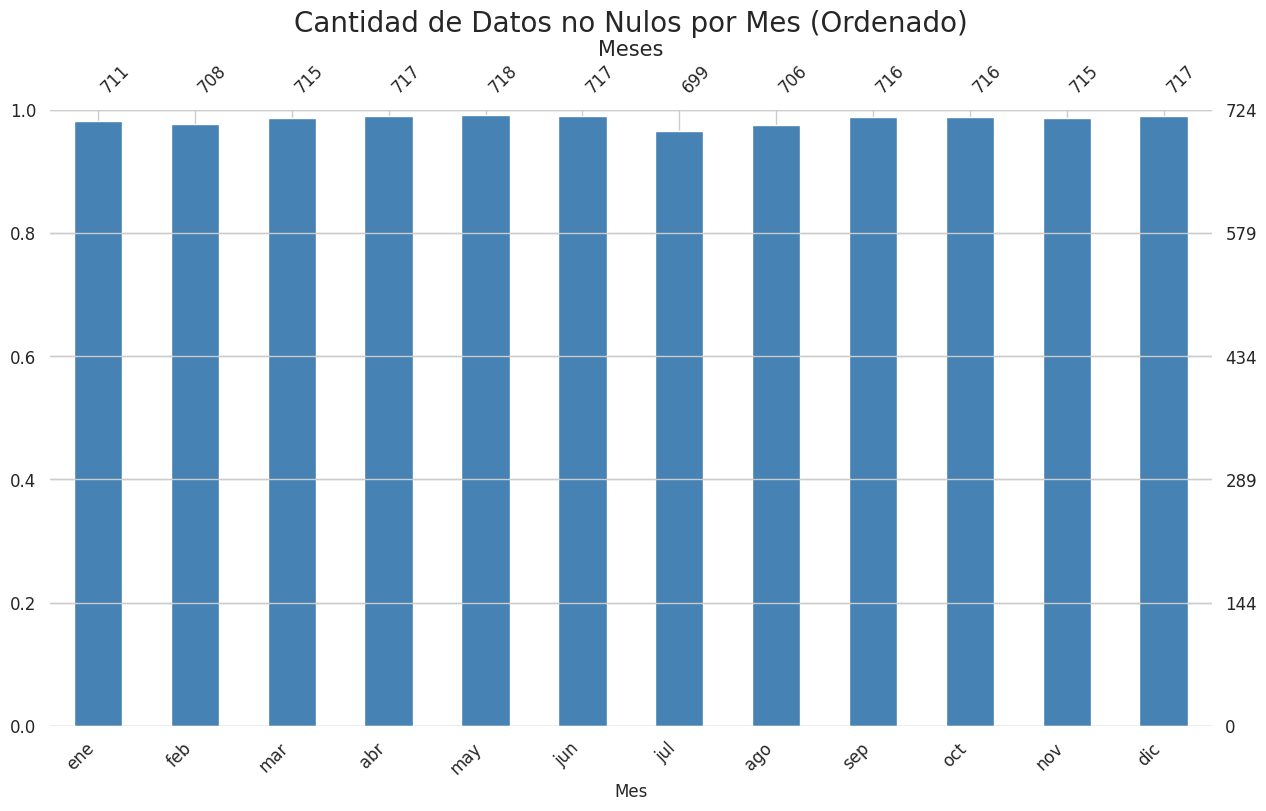

In [66]:
df_pivoted = df_enriquecido.pivot_table(
    index=['Estación', 'Variable'],
    columns='Mes',
    values='Valor'
)
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


<Axes: >

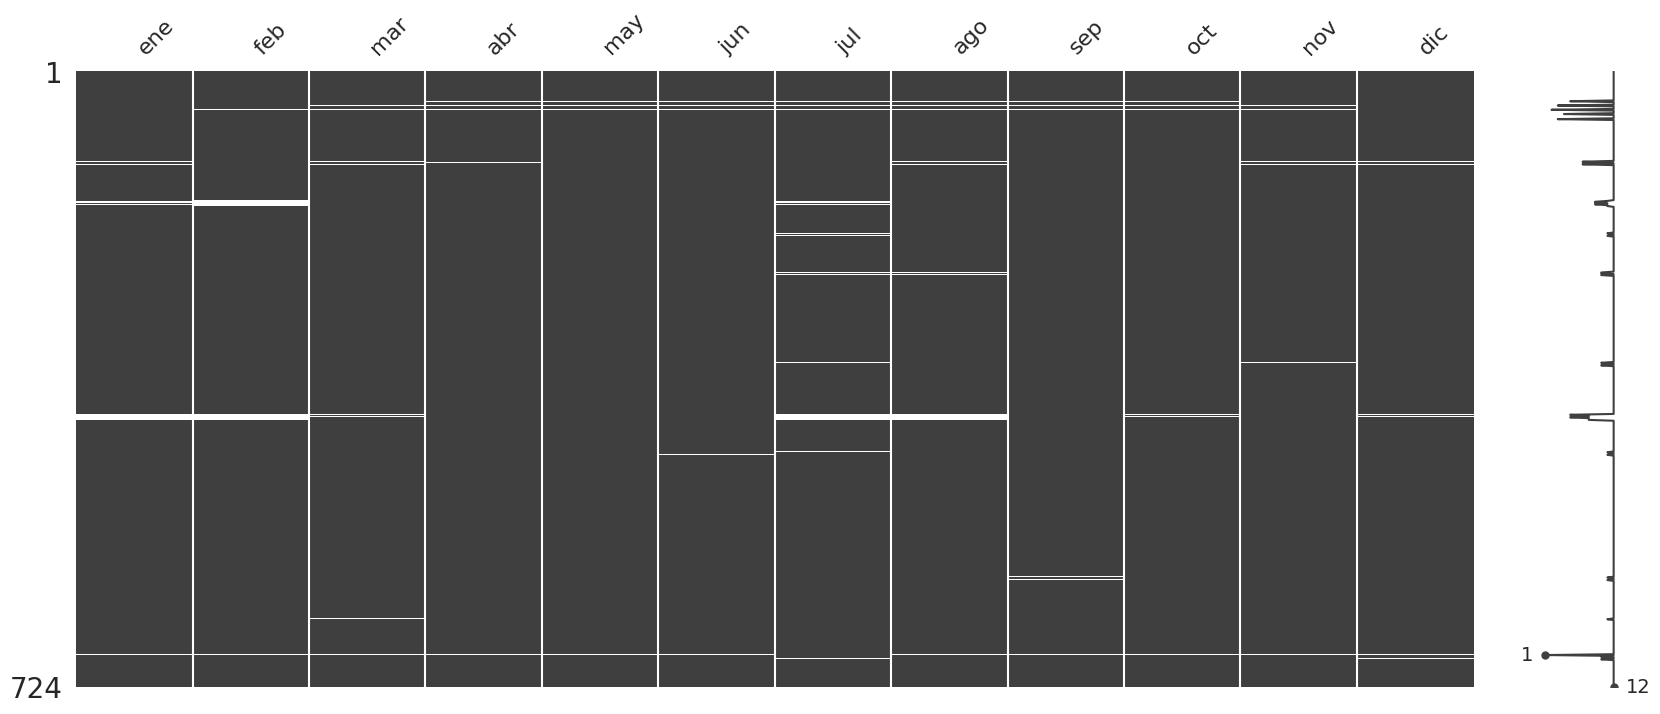

In [67]:
msno.matrix(df_pivoted, figsize=(20,8))

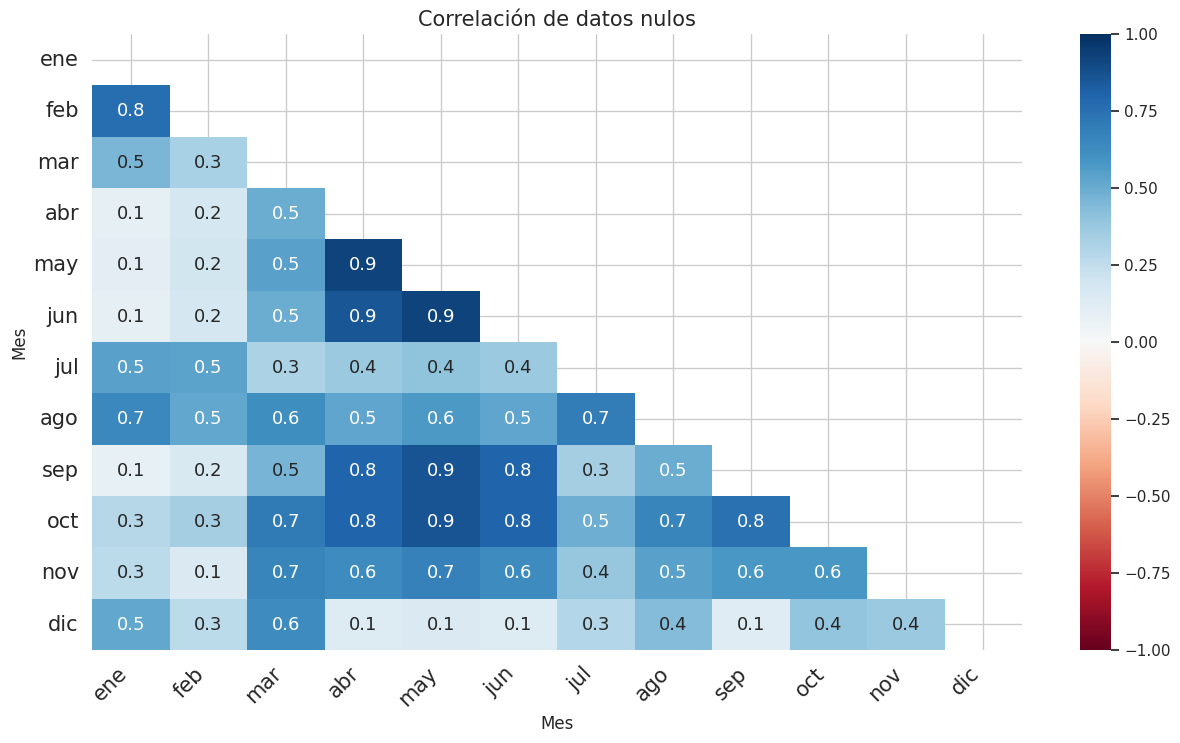

In [68]:
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

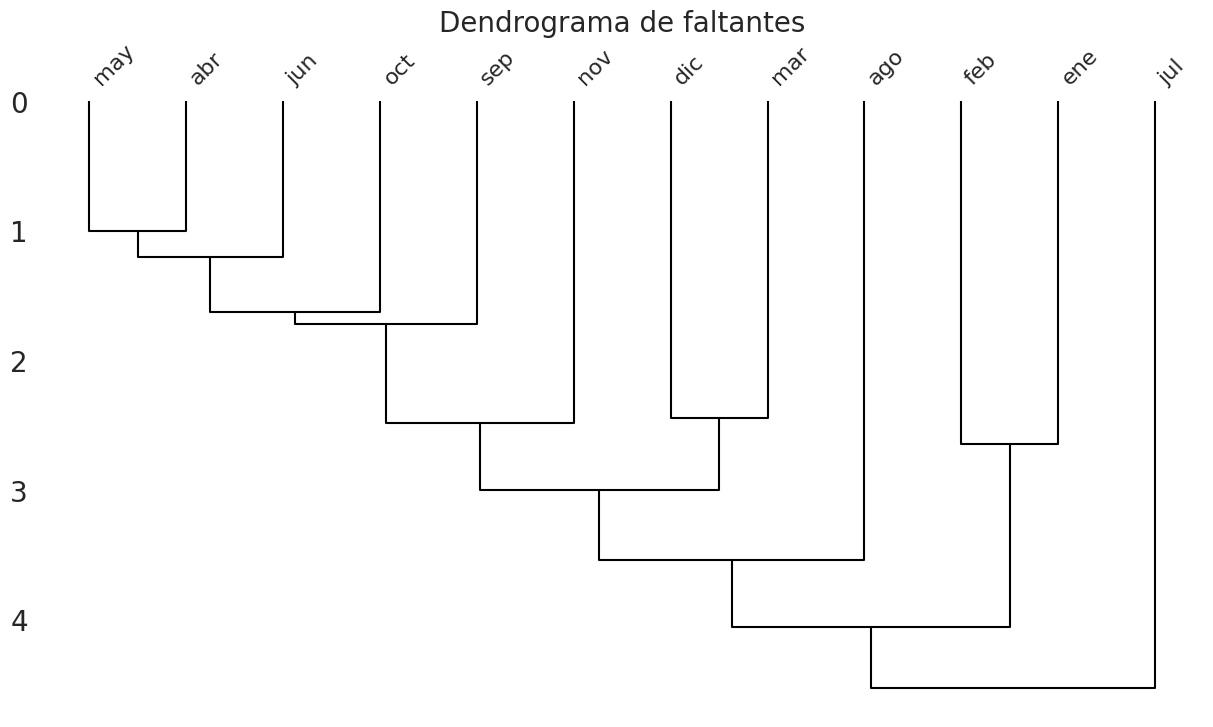

In [69]:
msno.dendrogram(df_pivoted, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [70]:
def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    return agrupar_nulos

# Ejemplos de análisis para 'Valor' (re-generamos para tener los DataFrames)
nulos_valor_por_estacion = nulos_por_grupo(df_enriquecido, 'Estación', 'Valor')
nulos_valor_por_variable = nulos_por_grupo(df_enriquecido, 'Variable', 'Valor')
nulos_valor_por_provincia = nulos_por_grupo(df_enriquecido, 'provincia', 'Valor')
nulos_valor_por_estacion_variable = nulos_por_grupo(df_enriquecido, ['Estación', 'Variable'], 'Valor')

# --- Cómo ordenar de mayor a menor ---

print("--- Nulos en 'Valor' por Estación (Ordenado de mayor a menor) ---")
nulos_age_por_estacion_ordenado = nulos_valor_por_estacion.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_age_por_estacion_ordenado, "\n")


print("--- Nulos en 'Valor' por Variable (Ordenado de mayor a menor) ---")
nulos_valor_por_variable_ordenado = nulos_valor_por_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_variable_ordenado, "\n")


print("--- Nulos en 'Valor' por provincia (Ordenado de mayor a menor) ---")
nulos_valor_por_provincia_ordenado = nulos_valor_por_provincia.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_provincia_ordenado, "\n")


print("--- Nulos en 'Valor' por Estación y Variable (Ordenado de mayor a menor) ---")
nulos_valor_por_estacion_variable_ordenado = nulos_valor_por_estacion_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_estacion_variable_ordenado, "\n")

--- Nulos en 'Valor' por Estación (Ordenado de mayor a menor) ---
               Estación  porcentaje_nulos_Valor
4      base_belgrano_ii               50.000000
7         base_marambio               47.916667
55                obera               47.916667
6        base_esperanza               46.875000
9       base_san_martin               46.875000
..                  ...                     ...
85     sauce_viejo_aero                0.000000
83      santa_rosa_aero                0.000000
91         tucuman_aero                0.000000
96   villa_dolores_aero                0.000000
97  villa_reynolds_aero                0.000000

[98 rows x 2 columns] 

--- Nulos en 'Valor' por Variable (Ordenado de mayor a menor) ---
                               Variable  porcentaje_nulos_Valor
7                  velocidad_viento_kmh               39.795918
0  frecuencia_dias_precipitacion_gt_1mm                9.778912
3                      precipitacion_mm                9.778912
1          


# Tipos de datos faltantes

### 1. MAR (Missing at Random)
* **Qué es:** la falta del dato se explica por otra variable que sí podemos observar.
* **Ejemplo:** la **velocidad del viento** falta por completo en la estación **Orán Aero**, probablemente porque esa estación no tenía el equipamiento necesario. La ausencia depende de la variable `Estación`.

### 2. MNAR (Missing Not at Random)
* **Qué es:** la falta del dato es causada por el propio valor que no se pudo medir.
* **Ejemplo:** un termómetro que se congela y deja de reportar datos solo cuando la temperatura es extremadamente baja. La ausencia depende del valor extremo que no se registró.

### 3. MCAR (Missing Completely at Random)
* **Qué es:** la ausencia es puramente accidental y no tiene relación con ninguna variable.
* **Ejemplo:** un error humano al anotar un único dato al azar. Es poco probable que explique los patrones sistemáticos de tus datos.

---

# Interpretación detallada de los nulos por grupos

El orden de los resultados por porcentaje de nulos ofrece una visión clara y rápida de dónde se concentran los valores faltantes en la columna `Valor`. A continuación, se analiza cada agrupación.

---

## 📊 Nulos en 'Valor' por estación


### Análisis
Se observa una clara concentración de nulos en las **estaciones antárticas** (`Base Belgrano II`, `Base Marambio`, `Base Esperanza`, `Base San Martín`) y `Obera`, con porcentajes de nulos extremadamente altos (entre 46.8% y 50%). Esto sugiere problemas crónicos de recolección o transmisión de datos debido a su ubicación remota o condiciones extremas. En contraste, muchas estaciones presentan un 0% de nulos.

### Implicación
Los datos **no son MCAR** (Missing Completely At Random). La ausencia de datos en `Valor` está fuertemente condicionada por la `Estación`. Es más probable que sean **MNAR** (Missing Not At Random), porque las fallas en los equipos se relacionan directamente con las condiciones extremas que se intentan medir.

---

## 🌡️ Nulos en 'Valor' por variable


### Análisis
Esta tabla es muy reveladora. La variable **`velocidad_viento_kmh` se destaca de forma drástica con casi un 40% de nulos**. Las variables de precipitación también tienen un porcentaje notablemente alto (casi 10%), mientras que las de temperatura y nubosidad presentan muy pocos nulos.

### Implicación
Nuevamente, los datos **no son MCAR**. La probabilidad de un valor nulo en `Valor` depende fuertemente de la `Variable` que se mide. Este es un fuerte indicio de **MAR**, donde la ausencia se explica por el tipo de medición. Por ejemplo, los anemómetros (medidores de viento) podrían ser más propensos a fallar que otros sensores.

---

## 🇦🇷 Nulos en 'Valor' por provincia


### Análisis
La provincia de **Antártida** es, con diferencia, la que presenta la mayor proporción de nulos (casi 45%), lo cual es consistente con el análisis por estación. Le siguen **Chaco** y **Misiones**. Por otro lado, un gran número de provincias no tienen ningún valor nulo.

### Implicación
Esto confirma que los datos **no son MCAR**. La `provincia` de origen es un factor muy importante que explica la presencia de nulos.

---

## 🔬 Nulos en 'Valor' por estación y variable

### Análisis
Esta tabla ofrece la prueba más contundente. Vemos que combinaciones específicas de `Estación` y `Variable` tienen un **100% de nulos**.

### Implicación
Definitivamente, los datos **no son MCAR**. La ausencia es **sistemática** y depende de la combinación de *dónde* (`Estación`) y *qué* (`Variable`) se mide. Esto es un caso claro de **MAR** e incluso podría tener componentes de **MNAR**, si la falta de registro se debe a que la medición es imposible de obtener en ciertas condiciones.

---

## 📜 Conclusión general

Con base en todos los análisis, podemos afirmar con alta confianza que los datos faltantes en la columna `Valor` **no son MCAR**. La distribución de los nulos es altamente dependiente de la `Estación` y de la `Variable`.

Esto indica que el mecanismo de pérdida es **MAR (Missing At Random)**, ya que la probabilidad de que un valor falte se relaciona de forma sistemática con otra información que sí tenemos en el conjunto de datos.


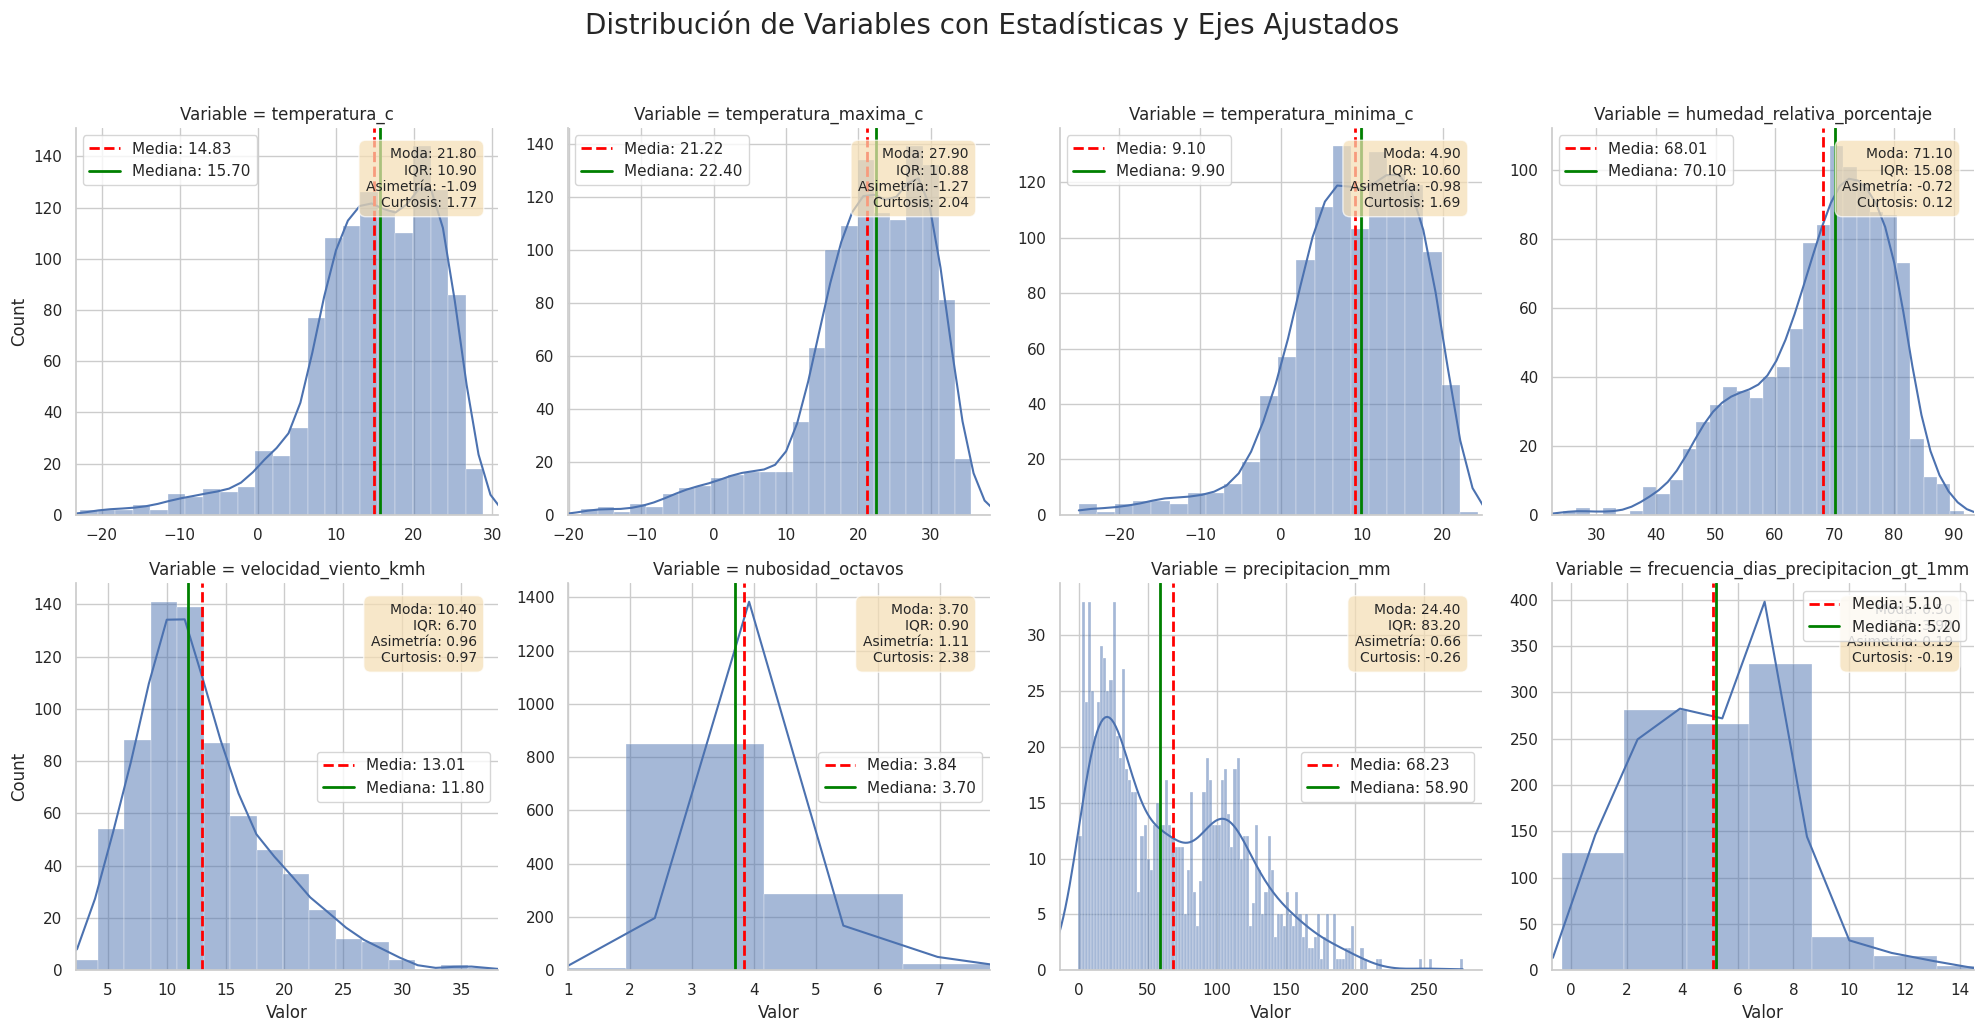

In [71]:
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max') 
)

g = sns.displot(
    data=df_enriquecido,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]
    stats_variable = estadisticas_generales.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.05
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle('Distribución de Variables con Estadísticas y Ejes Ajustados', y=1.03, fontsize=20)
g.tight_layout()
plt.show()

--- Estadísticas para la provincia de: MENDOZA ---
                                          media  mediana  moda     iqr  asimetria_pearson  curtosis_fisher  minimo  maximo
Variable                                                                                                                  
frecuencia_dias_precipitacion_gt_1mm   2.933333     2.95   2.8   1.800           0.066931        -0.632993     0.6     5.4
humedad_relativa_porcentaje           56.086667    54.10  53.8  13.350           0.007384        -1.014701    40.0    70.4
nubosidad_octavos                      2.993333     2.95   2.7   0.500           0.495182        -0.135989     2.3     4.0
precipitacion_mm                      24.185000    23.85   3.1  20.650           0.339670        -0.806592     3.1    54.2
temperatura_c                         15.586667    15.95   7.4  10.725          -0.056774        -1.272642     3.8    25.9
temperatura_maxima_c                  23.191667    23.45  15.3  10.650          -0.05797

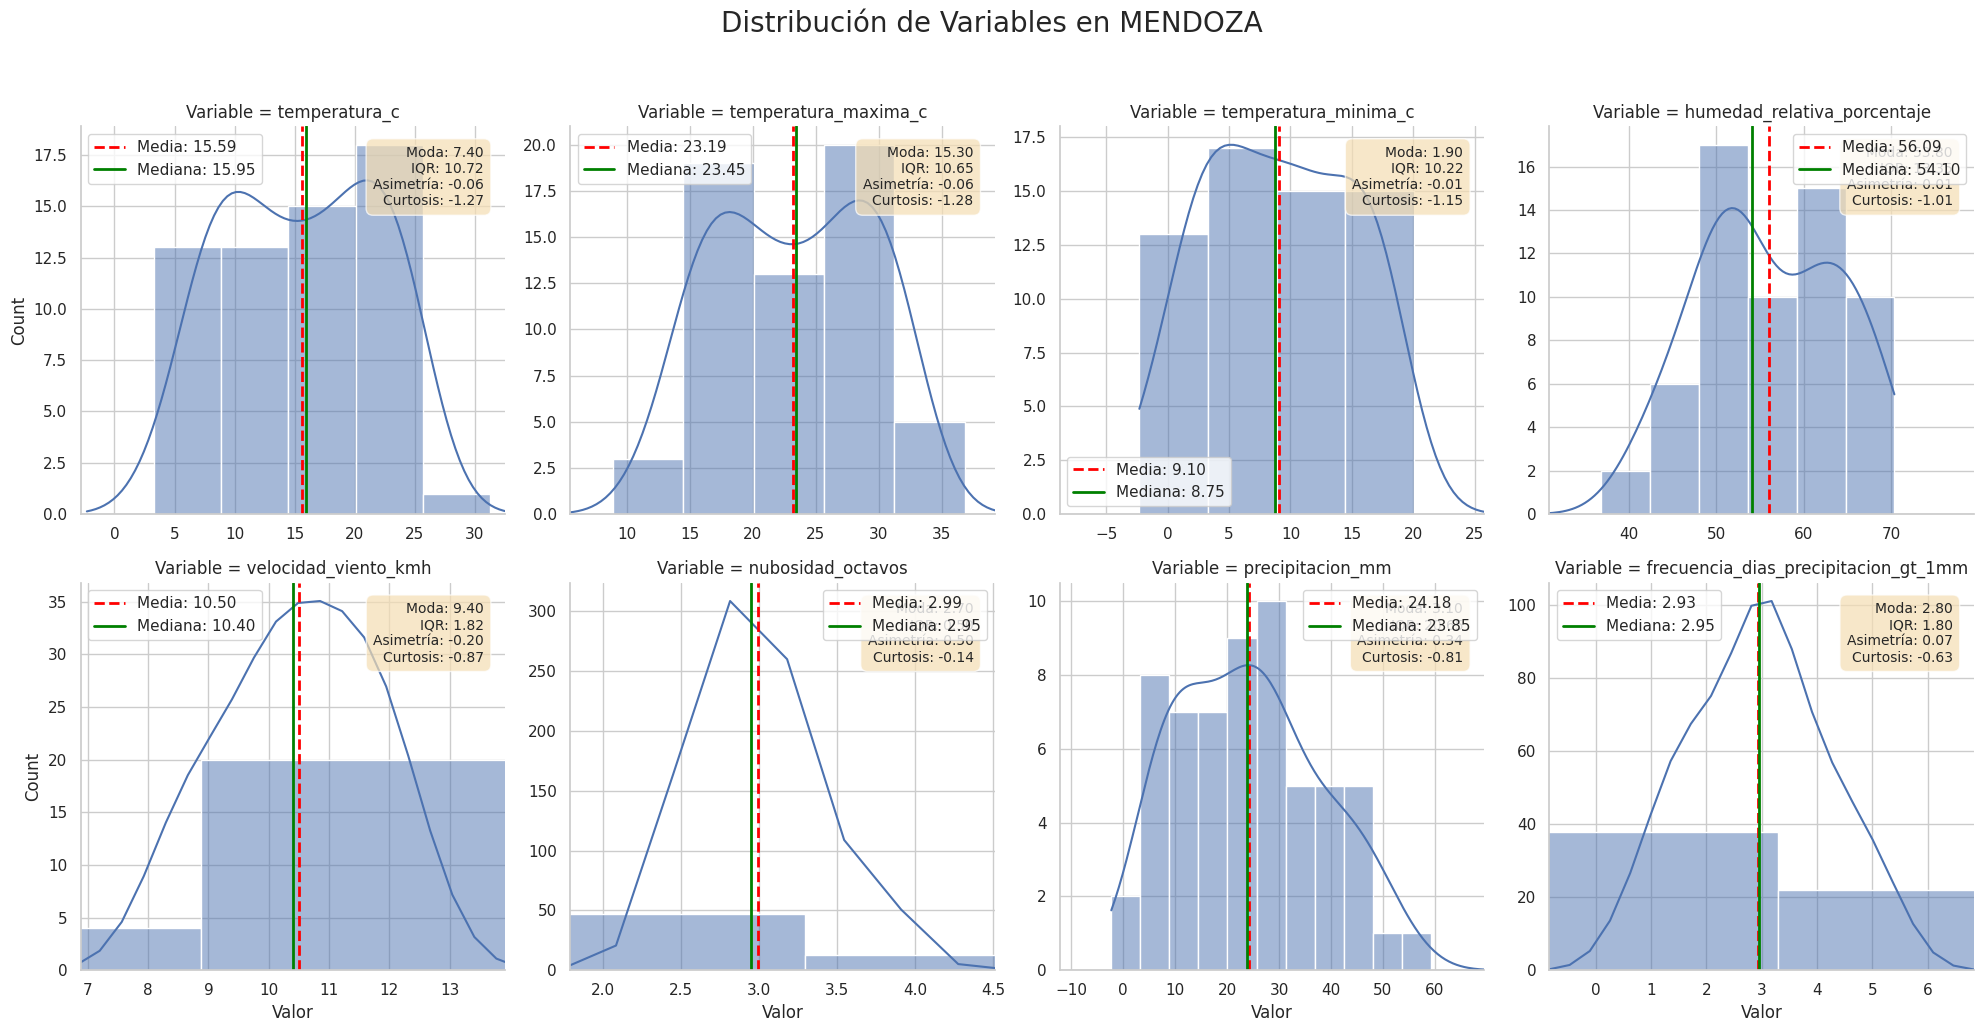

In [72]:
provincia_seleccionada = 'MENDOZA'  # Cambiar esto por la provincia que quieras analizar
df_provincia = df_enriquecido[df_enriquecido['provincia'] == provincia_seleccionada]

estadisticas_provincia = df_provincia.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max')
)

print(f"--- Estadísticas para la provincia de: {provincia_seleccionada} ---")
print(estadisticas_provincia)


g = sns.displot(
    data=df_provincia,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]

    stats_variable = estadisticas_provincia.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.30
        if padding == 0: padding = 1 
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle(f'Distribución de Variables en {provincia_seleccionada}', y=1.03, fontsize=20)
g.tight_layout()
plt.show()


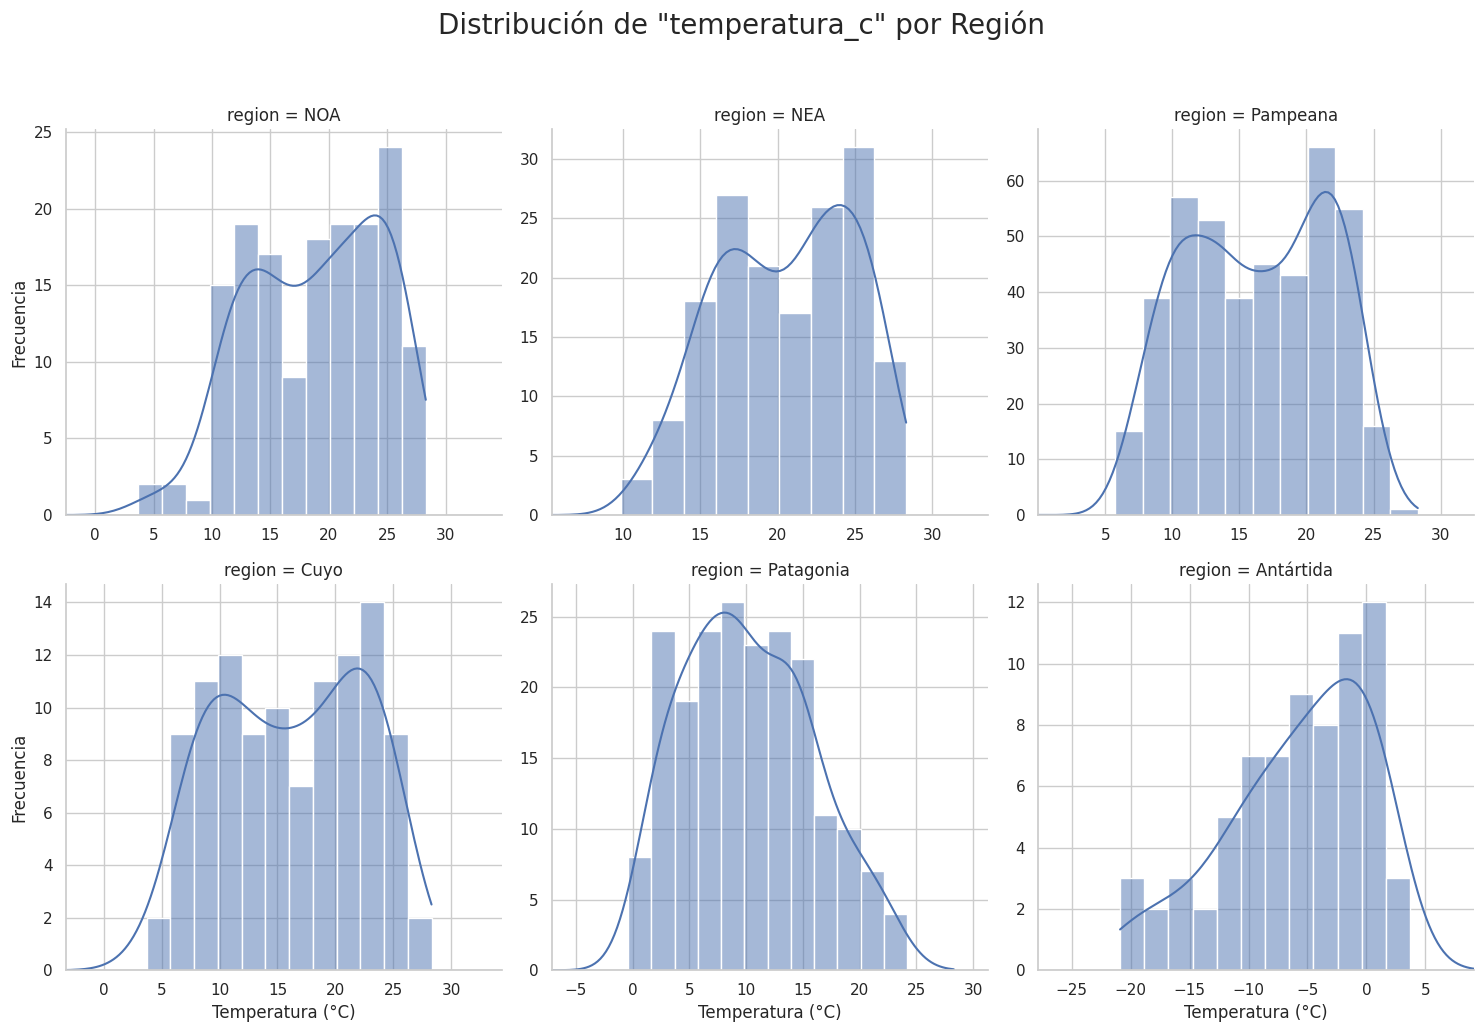

In [73]:
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'temperatura_c'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (°C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

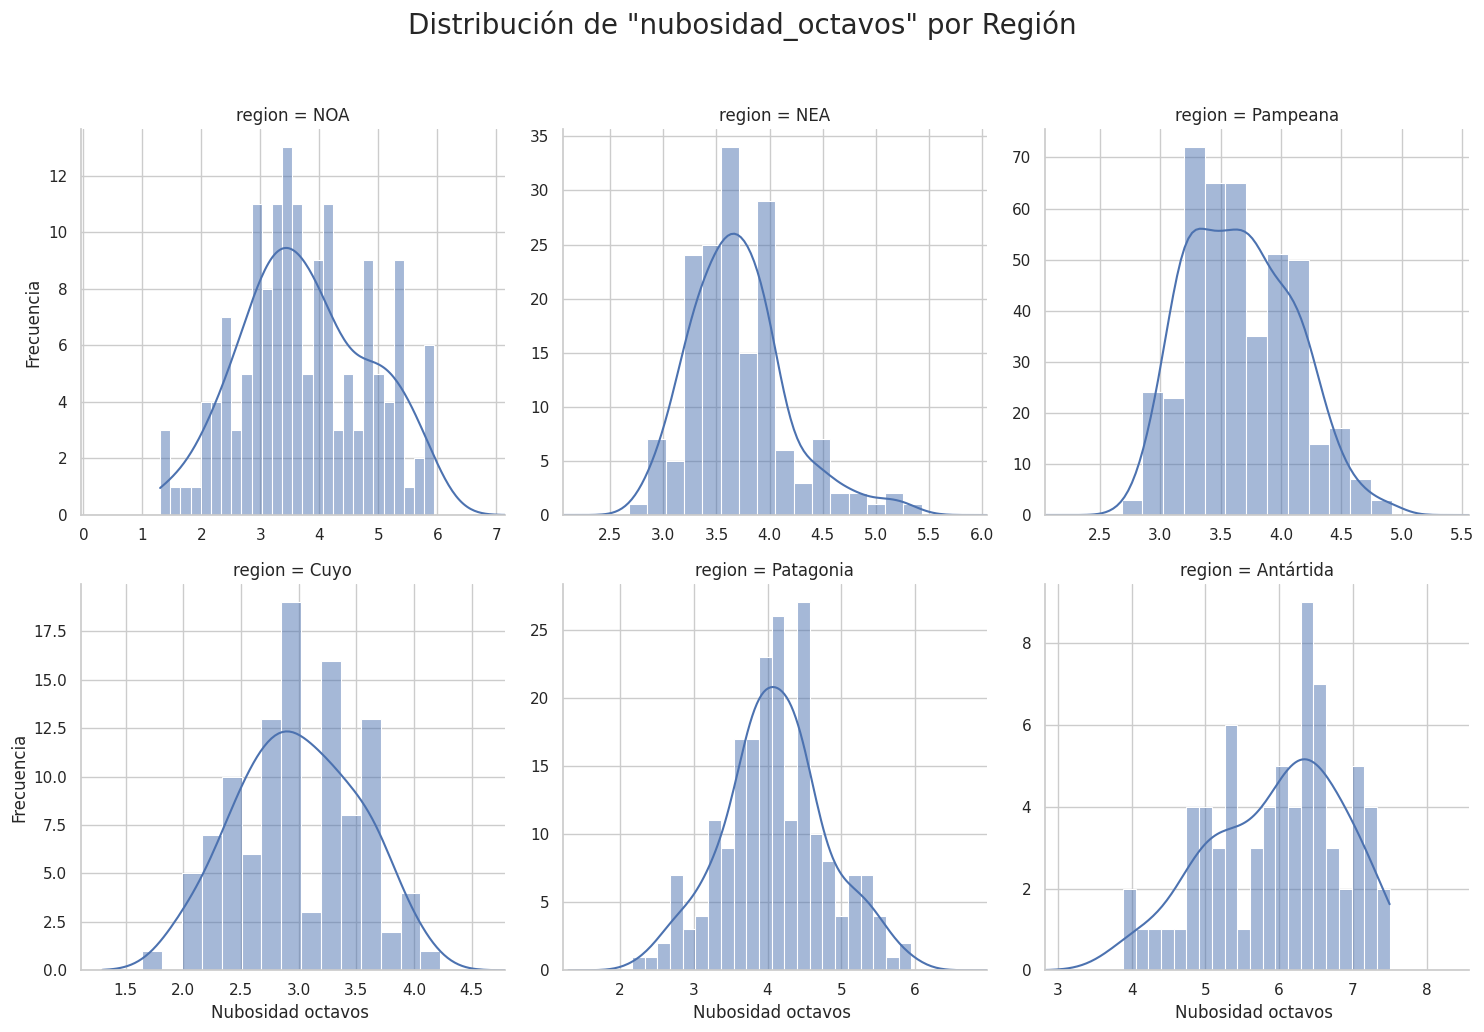

In [74]:
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'nubosidad_octavos'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región', y=1.03, fontsize=20)
g.set_axis_labels("Nubosidad octavos ", "Frecuencia")
g.fig.tight_layout()
plt.show()

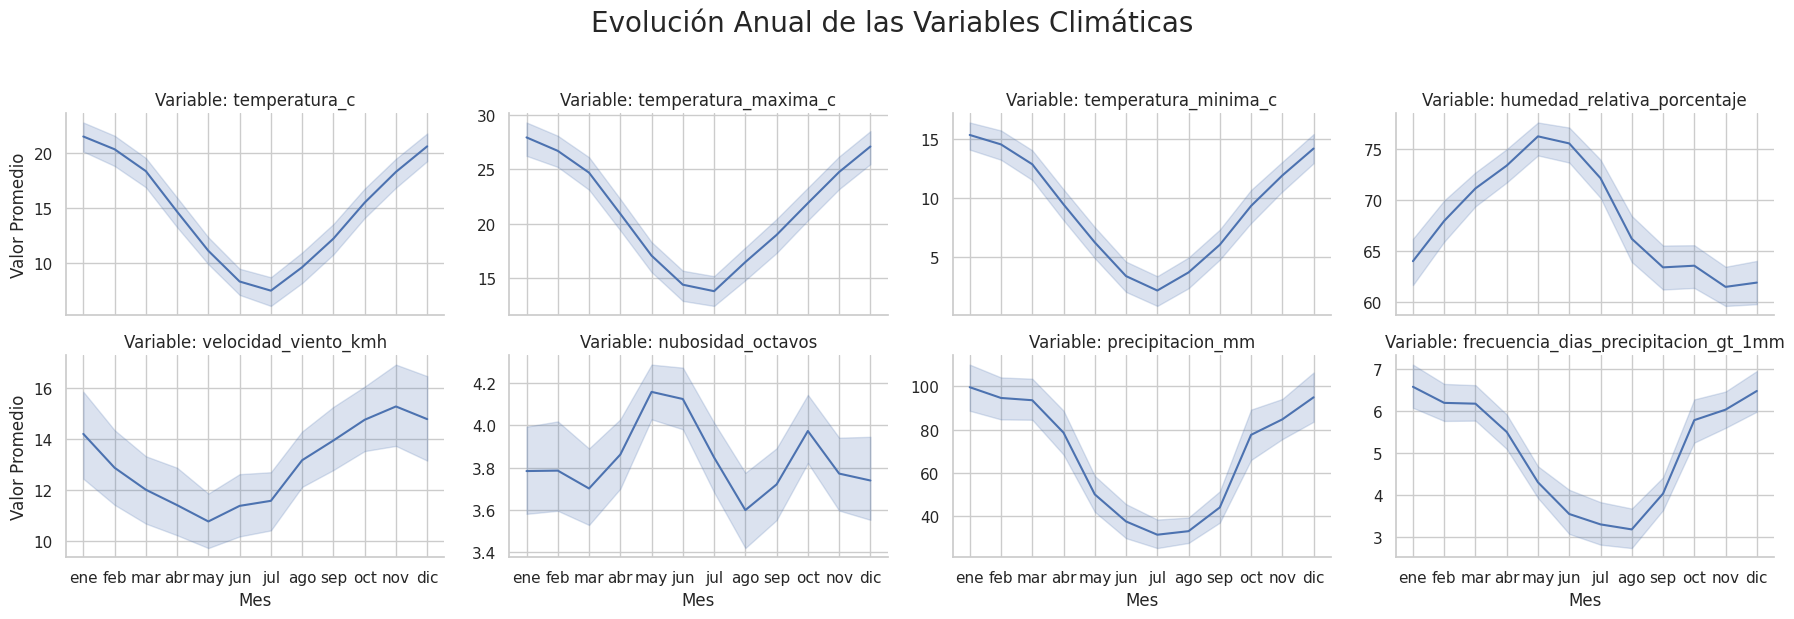

In [75]:
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=df_enriquecido,
    x='Mes',
    y='Valor',
    col='Variable',
    kind='line',
    col_wrap=4,
    height=3,
    aspect=1.5,
    facet_kws={'sharey': False, 'sharex': True}
)

g.fig.suptitle('Evolución Anual de las Variables Climáticas', y=1.03, fontsize=20)
g.set_titles("Variable: {col_name}")
g.set_axis_labels("Mes", "Valor Promedio")
plt.tight_layout()
plt.show()

## Descripción General de las Distribuciones de Variables Climáticas

A continuación, se presenta una descripción de la distribución y comportamiento de las variables climáticas, basándose en los gráficos de distribución y evolución anual proporcionados.

### 1. Temperatura ($temperatura\_c$)

* **Evolución Anual (General):** Sigue un patrón estacional claro, con valores promedio bajos en invierno (julio) y altos en verano (enero-febrero). La banda sombreada indica una variabilidad considerable a lo largo del año.
* **Distribución General:** La distribución general de la temperatura tiende a ser bimodal o presenta una ligera asimetría, con una cola más larga hacia valores más bajos. La media se sitúa alrededor de 14.83 °C y la mediana en 15.70 °C, sugiriendo una ligera asimetría negativa. El rango intercuartílico (IQR) es de 10.98, indicando una dispersión moderada. La curtosis de 1.77 sugiere colas más ligeras que una distribución normal.
* **Distribución en Mendoza:** En Mendoza, la distribución de la temperatura ($temperatura\_c$) se centra alrededor de una media de 15.59 °C y una mediana de 15.95 °C. Presenta un IQR de 10.72 y una curtosis de -1.27, lo que indica una distribución más aplanada (platicúrtica) y posiblemente bimodal o con dos picos, uno alrededor de 10-15°C y otro cerca de 20-25°C. La asimetría es de -0.06, lo que sugiere una distribución casi simétrica o ligeramente sesgada a la izquierda.
* **Distribución por Región:** La distribución de temperatura varía significativamente por región.
    * **NOA, NEA, Pampeana y Cuyo:** Muestran distribuciones que parecen bimodales o con un rango amplio de temperaturas, reflejando las variaciones estacionales. Las temperaturas promedio son más cálidas en estas regiones.
    * **Patagonia:** Presenta un rango de temperaturas más bajas y una distribución más concentrada en valores fríos, aunque con cierta variabilidad.
    * **Antártida:** Exhibe las temperaturas más bajas y una distribución notablemente sesgada hacia valores negativos, con un rango de temperatura mucho más frío en comparación con las demás regiones.

### 2. Temperatura Máxima ($temperatura\_maxima\_c$)

* **Evolución Anual (General):** Al igual que la temperatura promedio, la temperatura máxima muestra una clara estacionalidad, alcanzando sus picos en los meses de verano y sus mínimos en invierno.
* **Distribución General:** La distribución general de la temperatura máxima tiene una media de 21.22 °C y una mediana de 22.40 °C. El IQR es de 13.68, lo que indica una dispersión considerable. La asimetría de -0.08 sugiere una distribución casi simétrica. La curtosis de -0.94 indica que la distribución es más aplanada (platicúrtica) que una normal.
* **Distribución en Mendoza:** Para Mendoza, la temperatura máxima ($temperatura\_maxima\_c$) tiene una media de 23.19 °C y una mediana de 23.45 °C. El IQR es de 13.29, y la asimetría de -0.28 indica un ligero sesgo hacia valores más bajos. La curtosis de -1.20 sugiere una distribución más aplanada que la normal.

### 3. Temperatura Mínima ($temperatura\_minima\_c$)

* **Evolución Anual (General):** La temperatura mínima también sigue un patrón estacional, con los valores más bajos en invierno y los más altos en verano.
* **Distribución General:** La distribución general de la temperatura mínima muestra una media de 9.30 °C y una mediana de 9.90 °C. El IQR es de 10.60, indicando una dispersión similar a la temperatura máxima. La asimetría es de -0.08, sugiriendo una distribución casi simétrica. La curtosis de -1.69 indica que es más aplanada que una distribución normal.
* **Distribución en Mendoza:** La temperatura mínima ($temperatura\_minima\_c$) en Mendoza presenta una media de 8.94 °C y una mediana de 8.75 °C. Con un IQR de 10.22 y una asimetría de -0.01, la distribución es casi simétrica. La curtosis de -1.15 la hace más aplanada que una distribución normal.

### 4. Humedad Relativa ($humedad\_relativa\_porcentaje$)

* **Evolución Anual (General):** La humedad relativa muestra una tendencia estacional inversa a la temperatura, con valores más altos en los meses más fríos y más bajos en los meses más cálidos.
* **Distribución General:** La distribución general de la humedad relativa es multimodal o tiene una forma irregular. La media se encuentra en 68.01 % y la mediana en 70.10 %. El IQR de 13.08 indica una dispersión moderada. La asimetría de -0.22 sugiere un ligero sesgo hacia valores más altos de humedad. La curtosis de 0.12 indica una forma similar a una normal o ligeramente más puntiaguda.
* **Distribución en Mendoza:** En Mendoza, la humedad relativa ($humedad\_relativa\_porcentaje$) tiene una media de 56.09 % y una mediana de 54.10 %. El IQR es de 10.98 y la asimetría de -1.01, lo que indica un sesgo significativo hacia valores más altos de humedad. La curtosis de -1.01 sugiere una distribución más aplanada.

### 5. Velocidad del Viento ($velocidad\_viento\_kmh$)

* **Evolución Anual (General):** La velocidad del viento presenta cierta estacionalidad, con valores ligeramente más altos en primavera-verano y más bajos en invierno.
* **Distribución General:** La distribución general de la velocidad del viento parece tener una cola larga hacia valores más altos, indicando la ocurrencia de vientos fuertes ocasionales. La media es de 10.40 km/h y la mediana de 11.85 km/h. El IQR es de 6.94 y la asimetría de 0.96, confirmando un sesgo positivo (hacia la derecha). La curtosis de 0.97 indica colas más pesadas que una normal.
* **Distribución en Mendoza:** En Mendoza, la velocidad del viento ($velocidad\_viento\_kmh$) tiene una media de 10.50 km/h y una mediana de 10.40 km/h. El IQR es de 3.80, lo que sugiere una menor dispersión en comparación con la distribución general. La asimetría de 1.02 y una curtosis de 0.87 confirman un sesgo positivo y colas más pesadas.

### 6. Nubosidad ($nubosidad\_octavos$)

* **Evolución Anual (General):** La nubosidad muestra fluctuaciones a lo largo del año, con valores ligeramente más altos en los meses de invierno y primavera.
* **Distribución General:** La distribución general de la nubosidad es marcadamente asimétrica, concentrándose en valores bajos (poca nubosidad) y con una cola que se extiende hacia valores más altos (mayor nubosidad). La media es de 3.70 octavos y la mediana de 3.84 octavos. El IQR de 1.90 y la asimetría de 0.70 reflejan este sesgo positivo. La curtosis de 3.38 indica una distribución con un pico más agudo y colas más pesadas que una normal.
* **Distribución en Mendoza:** La nubosidad ($nubosidad\_octavos$) en Mendoza tiene una media de 2.99 octavos y una mediana de 3.00 octavos, lo que sugiere cielos generalmente menos nublados que en el promedio general. El IQR es de 0.50, lo que indica una distribución más concentrada. La asimetría de 0.14 y una curtosis de -1.04 sugieren una distribución más simétrica y aplanada en comparación con la distribución general.

### 7. Precipitación ($precipitacion\_mm$)

* **Evolución Anual (General):** La precipitación es altamente estacional, con los mayores volúmenes concentrados en los meses de verano (especialmente de diciembre a marzo) y mínimos en invierno.
* **Distribución General:** La distribución general de la precipitación está fuertemente sesgada hacia cero, con una gran cantidad de días sin precipitación o con muy poca, y una larga cola hacia valores más altos que representan eventos de lluvia intensos. La media es de 24.40 mm y la mediana de 68.22 mm. El IQR de 83.90 y la asimetría de 1.50 confirman un fuerte sesgo positivo. La curtosis de 0.26 indica colas más pesadas que una normal.
* **Distribución en Mendoza:** La precipitación ($precipitacion\_mm$) en Mendoza tiene una media de 24.18 mm y una mediana de 23.85 mm. El IQR de 60.90 y la asimetría de 0.81 indican un sesgo positivo, aunque posiblemente menos pronunciado que en la distribución general, reflejando el clima más árido de la región. La curtosis de -0.21 sugiere una distribución ligeramente más aplanada.

### 8. Frecuencia de Días con Precipitación > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$)

* **Evolución Anual (General):** La frecuencia de días con precipitación sigue un patrón estacional similar a la precipitación total, siendo más alta en los meses de verano y más baja en invierno.
* **Distribución General:** La distribución general de la frecuencia de días con precipitación > 1mm también está sesgada hacia valores bajos, indicando que los días con precipitación significativa son menos frecuentes. La media es de 5.10 días y la mediana de 5.20 días. El IQR de 1.90 y la asimetría de 0.19 sugieren un ligero sesgo positivo. La curtosis de -0.10 indica una forma similar a una distribución normal.
* **Distribución en Mendoza:** La frecuencia de días con precipitación > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$) en Mendoza tiene una media de 2.93 días y una mediana de 2.80 días. El IQR es de 0.83, lo que sugiere una menor variabilidad. La asimetría de 0.77 y una curtosis de 0.33 indican un sesgo positivo y colas ligeramente más pesadas, lo que es consistente con una región con menor frecuencia de lluvias significativas.

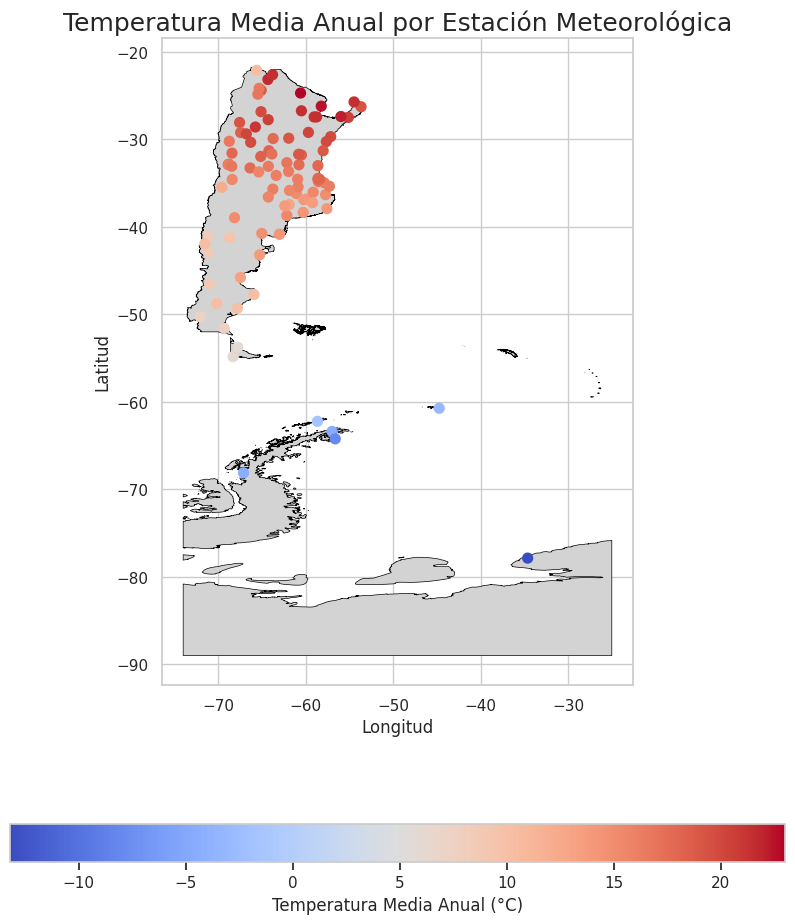

In [76]:

gdf_estaciones = geopandas.GeoDataFrame(
    df_bases, 
    geometry=geopandas.points_from_xy(df_bases.longitud, df_bases.latitud),
    crs="EPSG:4326"
)

# --- 2. Preparar los Datos a Visualizar ---
df_temperatura_media = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('Estación')['Valor'].mean().reset_index()
df_temperatura_media.rename(columns={'Valor': 'temp_media_anual'}, inplace=True)
# --- 3. Unir Datos  ---
gdf_final_para_mapa = pd.merge(
    gdf_estaciones,
    df_temperatura_media,
    on='Estación',
    how='inner'
)

# --- 4. Dibujar el Mapa ---
ruta_al_mapa = "datos/pais/paisPolygon.shp"  # <-- CAMBIÁ ESTA RUTA
argentina_mapa = geopandas.read_file(ruta_al_mapa)


# Creamos la figura y el eje del gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Dibujamos el mapa de provincias como base
argentina_mapa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Superponemos los puntos de las estaciones
gdf_final_para_mapa.plot(
    column='temp_media_anual', 
    ax=ax, 
    legend=True,
    cmap='coolwarm',
    markersize=50,
    legend_kwds={'label': "Temperatura Media Anual (°C)", 'orientation': "horizontal"}
)

# Configuramos el título y los ejes
ax.set_title('Temperatura Media Anual por Estación Meteorológica', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

Columnas disponibles en el mapa final: Index(['gid', 'entidad', 'fna', 'gna', 'nam', 'in1', 'fdc', 'sag', 'geometry', 'provincia_limpia', 'provincia', 'temp_media_provincial'], dtype='object')


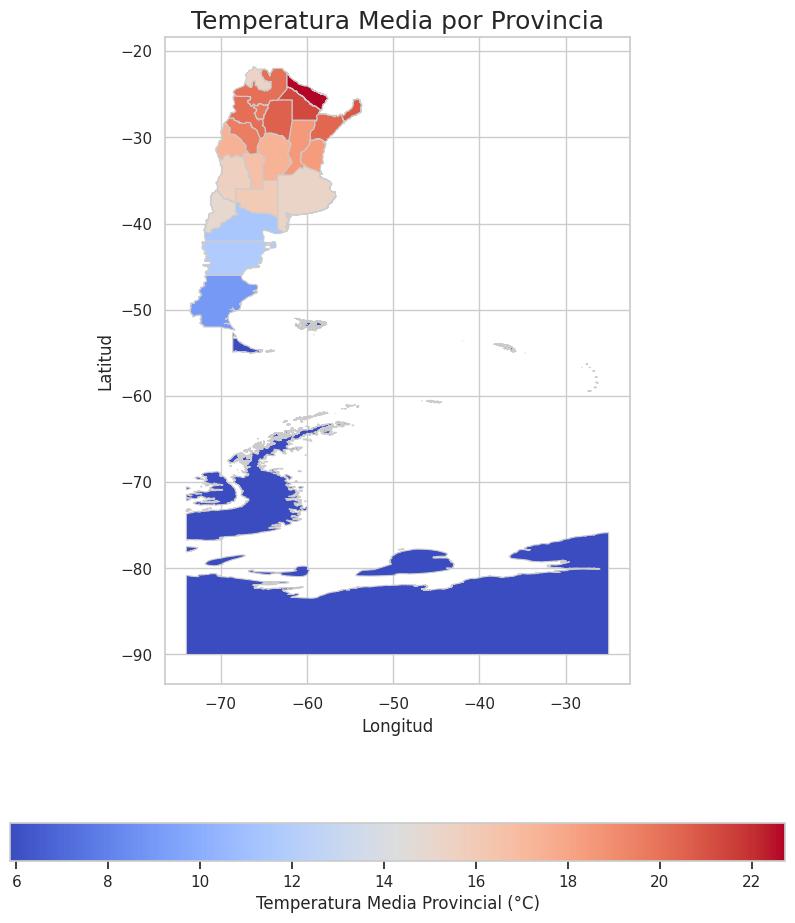

In [77]:
# a) Calcular la temperatura media por provincia
df_temp_provincia = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('provincia')['Valor'].mean().reset_index()

# b) Renombrar la columna 'Valor' a su nombre final
df_temp_provincia.rename(columns={'Valor': 'temp_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la unión
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia_limpia'].replace(mapa_correcciones)


# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)


mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)


# --- 3. UNIR LOS DATAFRAMES ---

mapa_final = pd.merge(
    mapa_provincias,
    df_temp_provincia,
    on='provincia_limpia',
    how='left'
)


# --- 4. DIBUJAR EL MAPA ---

print("Columnas disponibles en el mapa final:", mapa_final.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final.plot(
    column='temp_media_provincial',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "Temperatura Media Provincial (°C)", 'orientation': "horizontal"}
)

ax.set_title('Temperatura Media por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

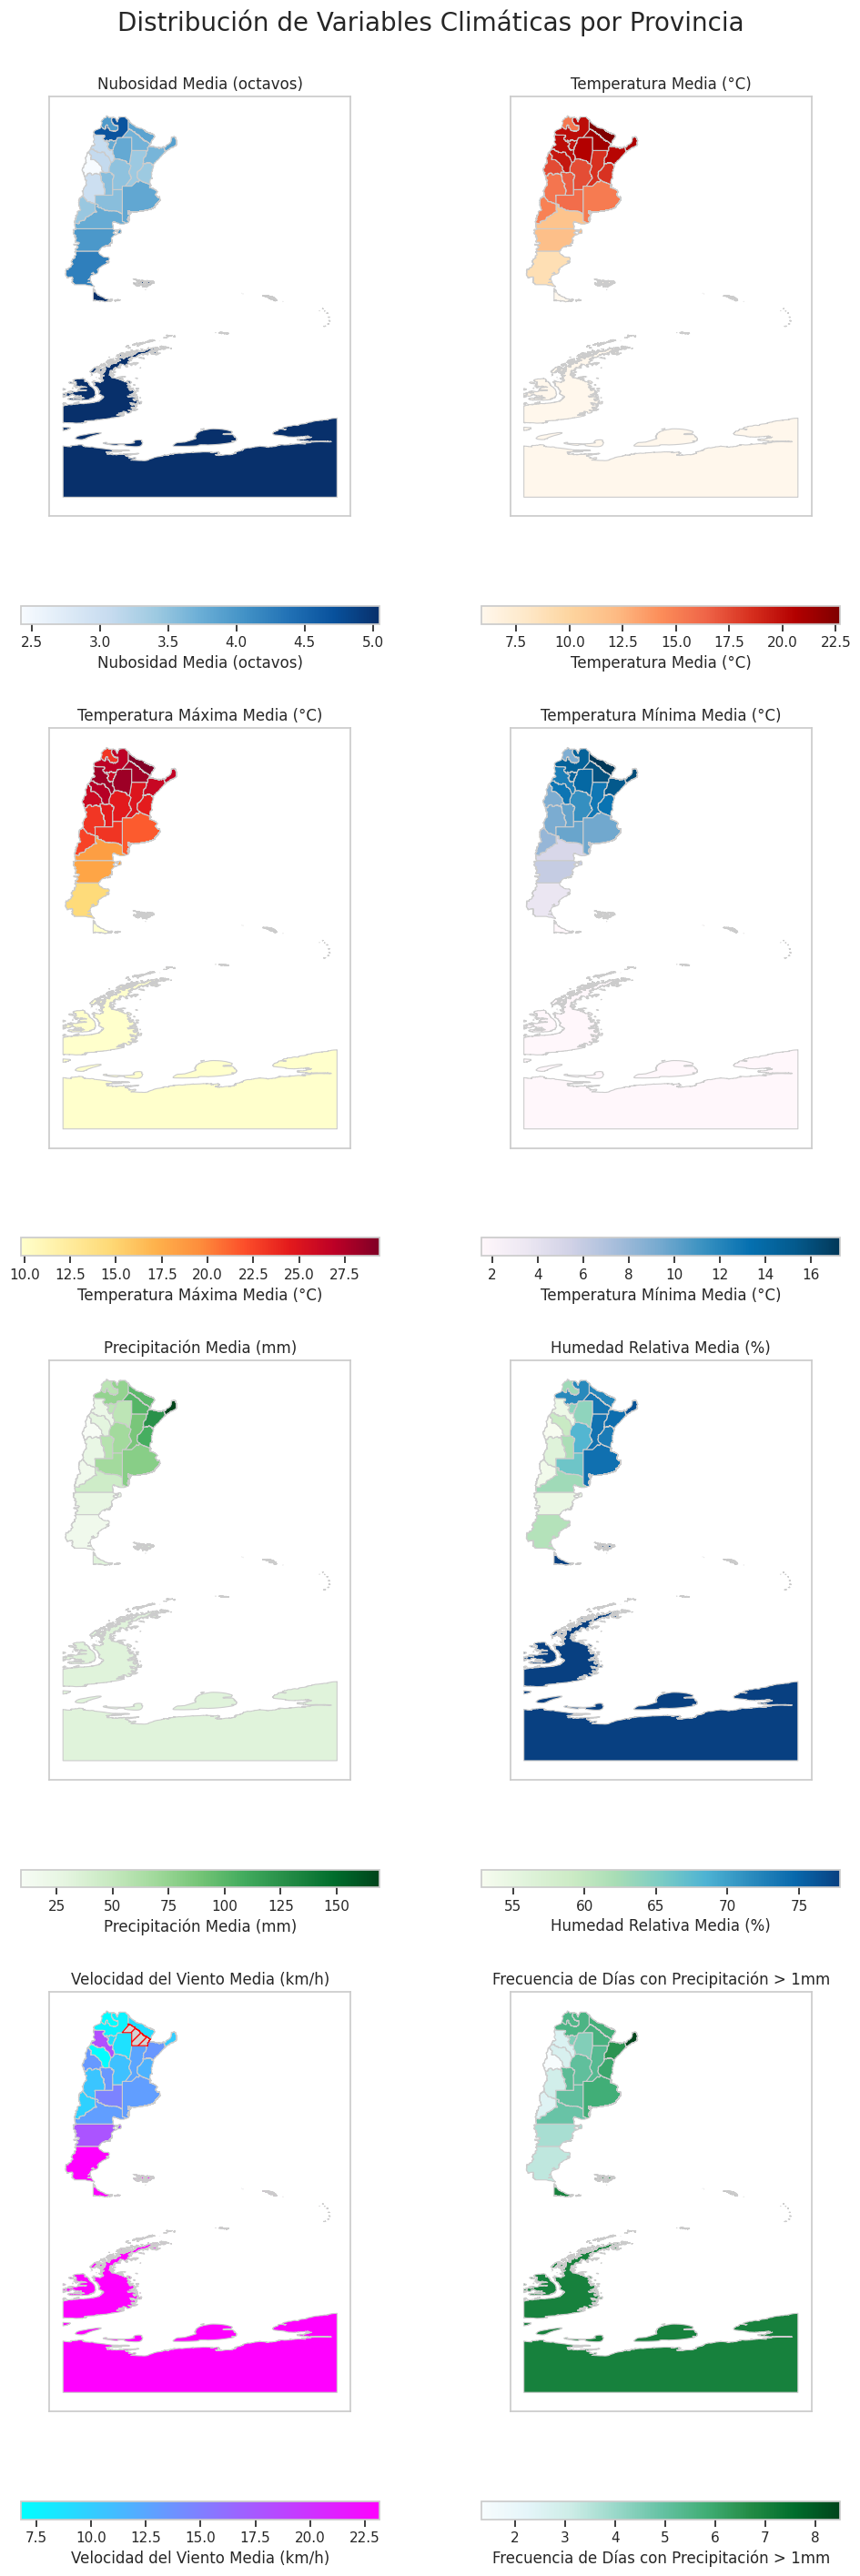

In [78]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt


# --- 1. PREPARAR DATOS DE NUBOSIDAD (como en tu código original) ---
df_nubo_provincia = df_enriquecido[df_enriquecido['Variable'] == 'nubosidad_octavos'].groupby('provincia')['Valor'].mean().reset_index()
df_nubo_provincia.rename(columns={'Valor': 'nubo_media_provincial'}, inplace=True)
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia'].apply(limpiar_texto)
mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia_limpia'].replace(mapa_correcciones)

# --- 2. PREPARAR DATOS DEL MAPA (como en tu código original) ---
ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

# --- 3. DICCIONARIO DE VARIABLES A PLOTEAR Y SUS PROPIEDADES ---
variables_a_plotear = {
    'nubosidad_octavos': {
        'nombre_columna': 'nubo_media_provincial',
        'titulo': 'Nubosidad Media (octavos)',
        'cmap': 'Blues'
    },
      'temperatura_c': { 
        'nombre_columna': 'temp_media_provincial',
        'titulo': 'Temperatura Media (°C)',
        'cmap': 'OrRd'
    },
    'temperatura_maxima_c': {
        'nombre_columna': 'temp_max_media_provincial',
        'titulo': 'Temperatura Máxima Media (°C)',
        'cmap': 'YlOrRd'
    },
    'temperatura_minima_c': {
        'nombre_columna': 'temp_min_media_provincial',
        'titulo': 'Temperatura Mínima Media (°C)',
        'cmap': 'PuBu'
    },
    'precipitacion_mm': {
        'nombre_columna': 'precip_media_provincial',
        'titulo': 'Precipitación Media (mm)',
        'cmap': 'Greens'
    },
    'humedad_relativa_porcentaje': {
        'nombre_columna': 'humedad_media_provincial',
        'titulo': 'Humedad Relativa Media (%)',
        'cmap': 'GnBu'
    },
    'velocidad_viento_kmh': {
        'nombre_columna': 'viento_media_provincial',
        'titulo': 'Velocidad del Viento Media (km/h)',
        'cmap': 'cool'
    },
    'frecuencia_dias_precipitacion_gt_1mm': {
        'nombre_columna': 'frec_precip_media_provincial',
        'titulo': 'Frecuencia de Días con Precipitación > 1mm',
        'cmap': 'BuGn'
    }
}

# --- 4. CREAR EL SUBPLOT DE MAPAS ---
n_variables = len(variables_a_plotear)
ncols = 2
nrows = (n_variables + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 7)) # Ajusta el tamaño de la figura
axes = axes.flatten() 

for i, (variable_original, props) in enumerate(variables_a_plotear.items()):
    ax = axes[i]

    # Prepara los datos para la variable actual
    df_variable_provincia = df_enriquecido[df_enriquecido['Variable'] == variable_original].groupby('provincia')['Valor'].mean().reset_index()
    df_variable_provincia.rename(columns={'Valor': props['nombre_columna']}, inplace=True)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia'].apply(limpiar_texto)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia_limpia'].replace(mapa_correcciones)

    # Une los dataframes
    mapa_final_variable = pd.merge(
        mapa_provincias,
        df_variable_provincia,
        on='provincia_limpia',
        how='left'
    )

    # Dibuja el mapa
    mapa_final_variable.plot(
        column=props['nombre_columna'],
        ax=ax,
        legend=True,
        cmap=props['cmap'],
        linewidth=0.8,
        edgecolor='0.8',
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Sin datos",
        },
        legend_kwds={'label': props['titulo'], 'orientation': "horizontal", 'shrink': 0.6} # Shrink para reducir el tamaño de la leyenda
    )

    ax.set_title(props['titulo'], fontsize=12)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_aspect('equal')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Ajusta el layout para evitar solapamientos
plt.suptitle('Distribución de Variables Climáticas por Provincia', fontsize=20, y=1.02) # Título general
plt.show()

In [79]:
#--- 1. Estadísticas Generales por Variable ---
print("--- 1. Estadísticas Generales por Variable ---")
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_generales)

print("\n--- Moda por Variable ---")
moda_general = df_enriquecido.groupby('Variable')['Valor'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
print(moda_general)


# --- 2. Estadísticas por Región y Variable ---
print("\n" + "="*80)
print("--- 2. Estadísticas por Región y Variable ---")
estadisticas_por_region = df_enriquecido.groupby(['region', 'Variable']).agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_por_region)

--- 1. Estadísticas Generales por Variable ---
                                      conteo      media  desvio_est     varianza  mediana  minimo  maximo  asimetria_pearson  curtosis_fisher
Variable                                                                                                                                     
frecuencia_dias_precipitacion_gt_1mm    1061   5.097455    2.536586     6.434267      5.2     0.0    13.8           0.185539        -0.186138
humedad_relativa_porcentaje             1110  68.005405   11.027475   121.605201     70.1    25.7    90.2          -0.719815         0.118628
nubosidad_octavos                       1166   3.840137    0.888284     0.789049      3.7     1.3     7.5           1.109340         2.384159
precipitacion_mm                        1061  68.234873   51.674519  2670.255915     58.9     0.0   277.9           0.663766        -0.262990
temperatura_c                           1167  14.834190    8.178787    66.892561     15.7   -20.9    

## Outlaiers

/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


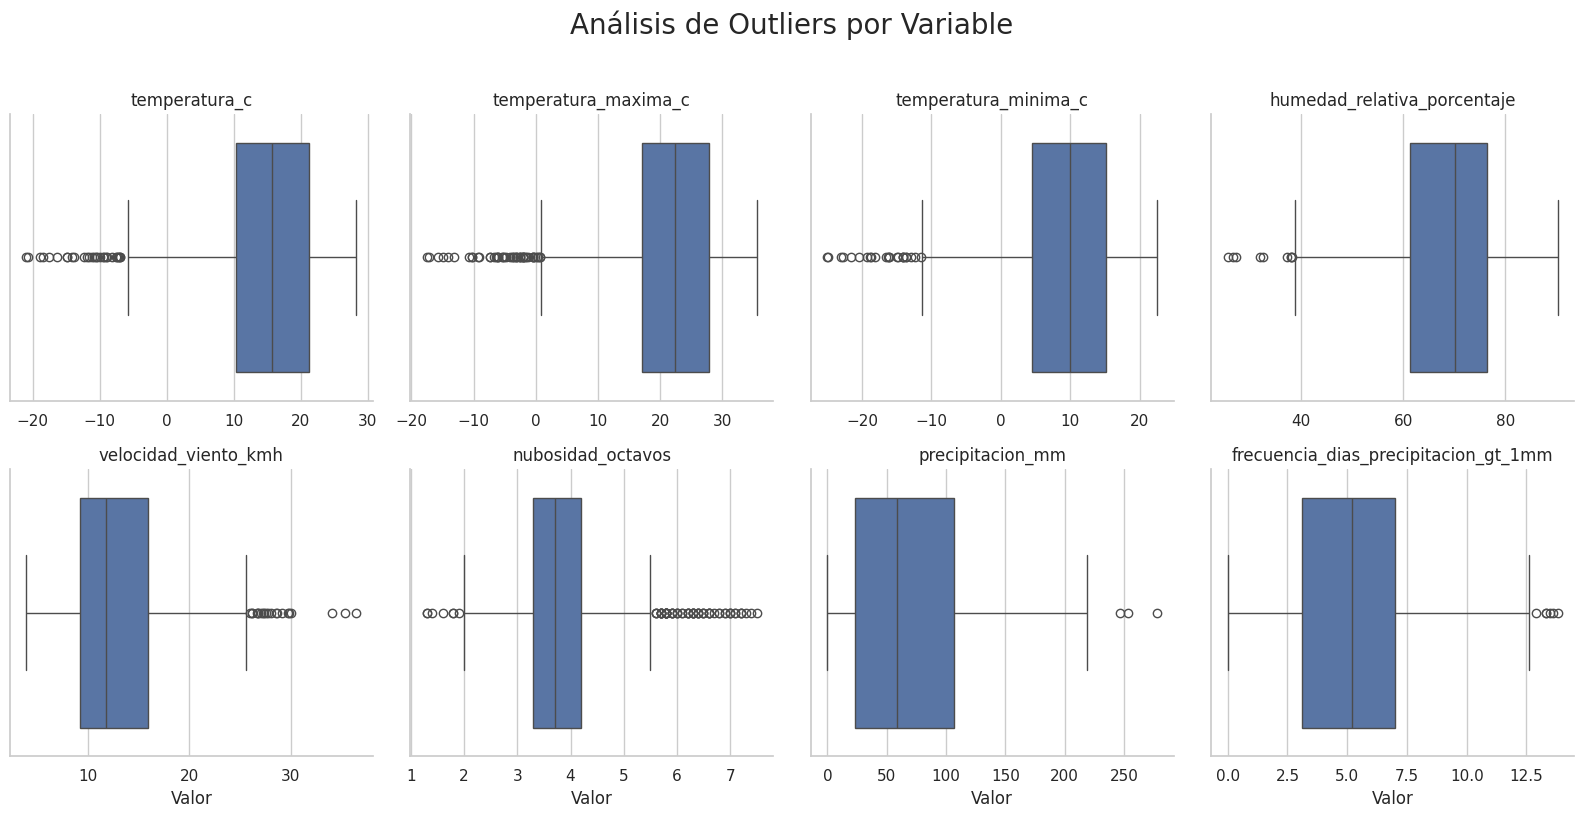

In [80]:
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=4, 
    sharey=False, 
    sharex=False, 
    height=4
)

g.map(sns.boxplot, "Valor")

g.set_axis_labels("Valor", "")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [81]:
Q1 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.25)
Q3 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

limites = pd.DataFrame({'lim_inf': limite_inferior, 'lim_sup': limite_superior})
print("--- Límites para detección de outliers por Variable ---")
print(limites)

df_con_limites = pd.merge(df_enriquecido, limites, on='Variable', how='left')

outliers_generales = df_con_limites[
    (df_con_limites['Valor'] < df_con_limites['lim_inf']) | 
    (df_con_limites['Valor'] > df_con_limites['lim_sup'])
]

conteo_de_outliers = outliers_generales['Variable'].value_counts()

total_por_variable = df_enriquecido['Variable'].value_counts()

resumen_outliers = pd.DataFrame({
    'total_registros': total_por_variable,
    'cantidad_outliers': conteo_de_outliers
}).fillna(0)

resumen_outliers['porcentaje_outliers'] = (resumen_outliers['cantidad_outliers'] / resumen_outliers['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Variable ---")
print(resumen_outliers)

--- Límites para detección de outliers por Variable ---
                                       lim_inf   lim_sup
Variable                                                
frecuencia_dias_precipitacion_gt_1mm   -2.7500   12.8500
humedad_relativa_porcentaje            38.7125   99.0125
nubosidad_octavos                       1.9500    5.5500
precipitacion_mm                     -101.5000  231.3000
temperatura_c                          -6.0500   37.5500
temperatura_maxima_c                    0.7125   44.2125
temperatura_minima_c                  -11.4000   31.0000
velocidad_viento_kmh                   -0.8500   25.9500

--- Resumen Porcentual de Outliers por Variable ---
                                      total_registros  cantidad_outliers  porcentaje_outliers
Variable                                                                                     
frecuencia_dias_precipitacion_gt_1mm             1176                  6             0.510204
humedad_relativa_porcentaje            


--- Regiones encontradas: NOA, NEA, Pampeana, Cuyo, nan, Patagonia, Antártida ---


/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: Future

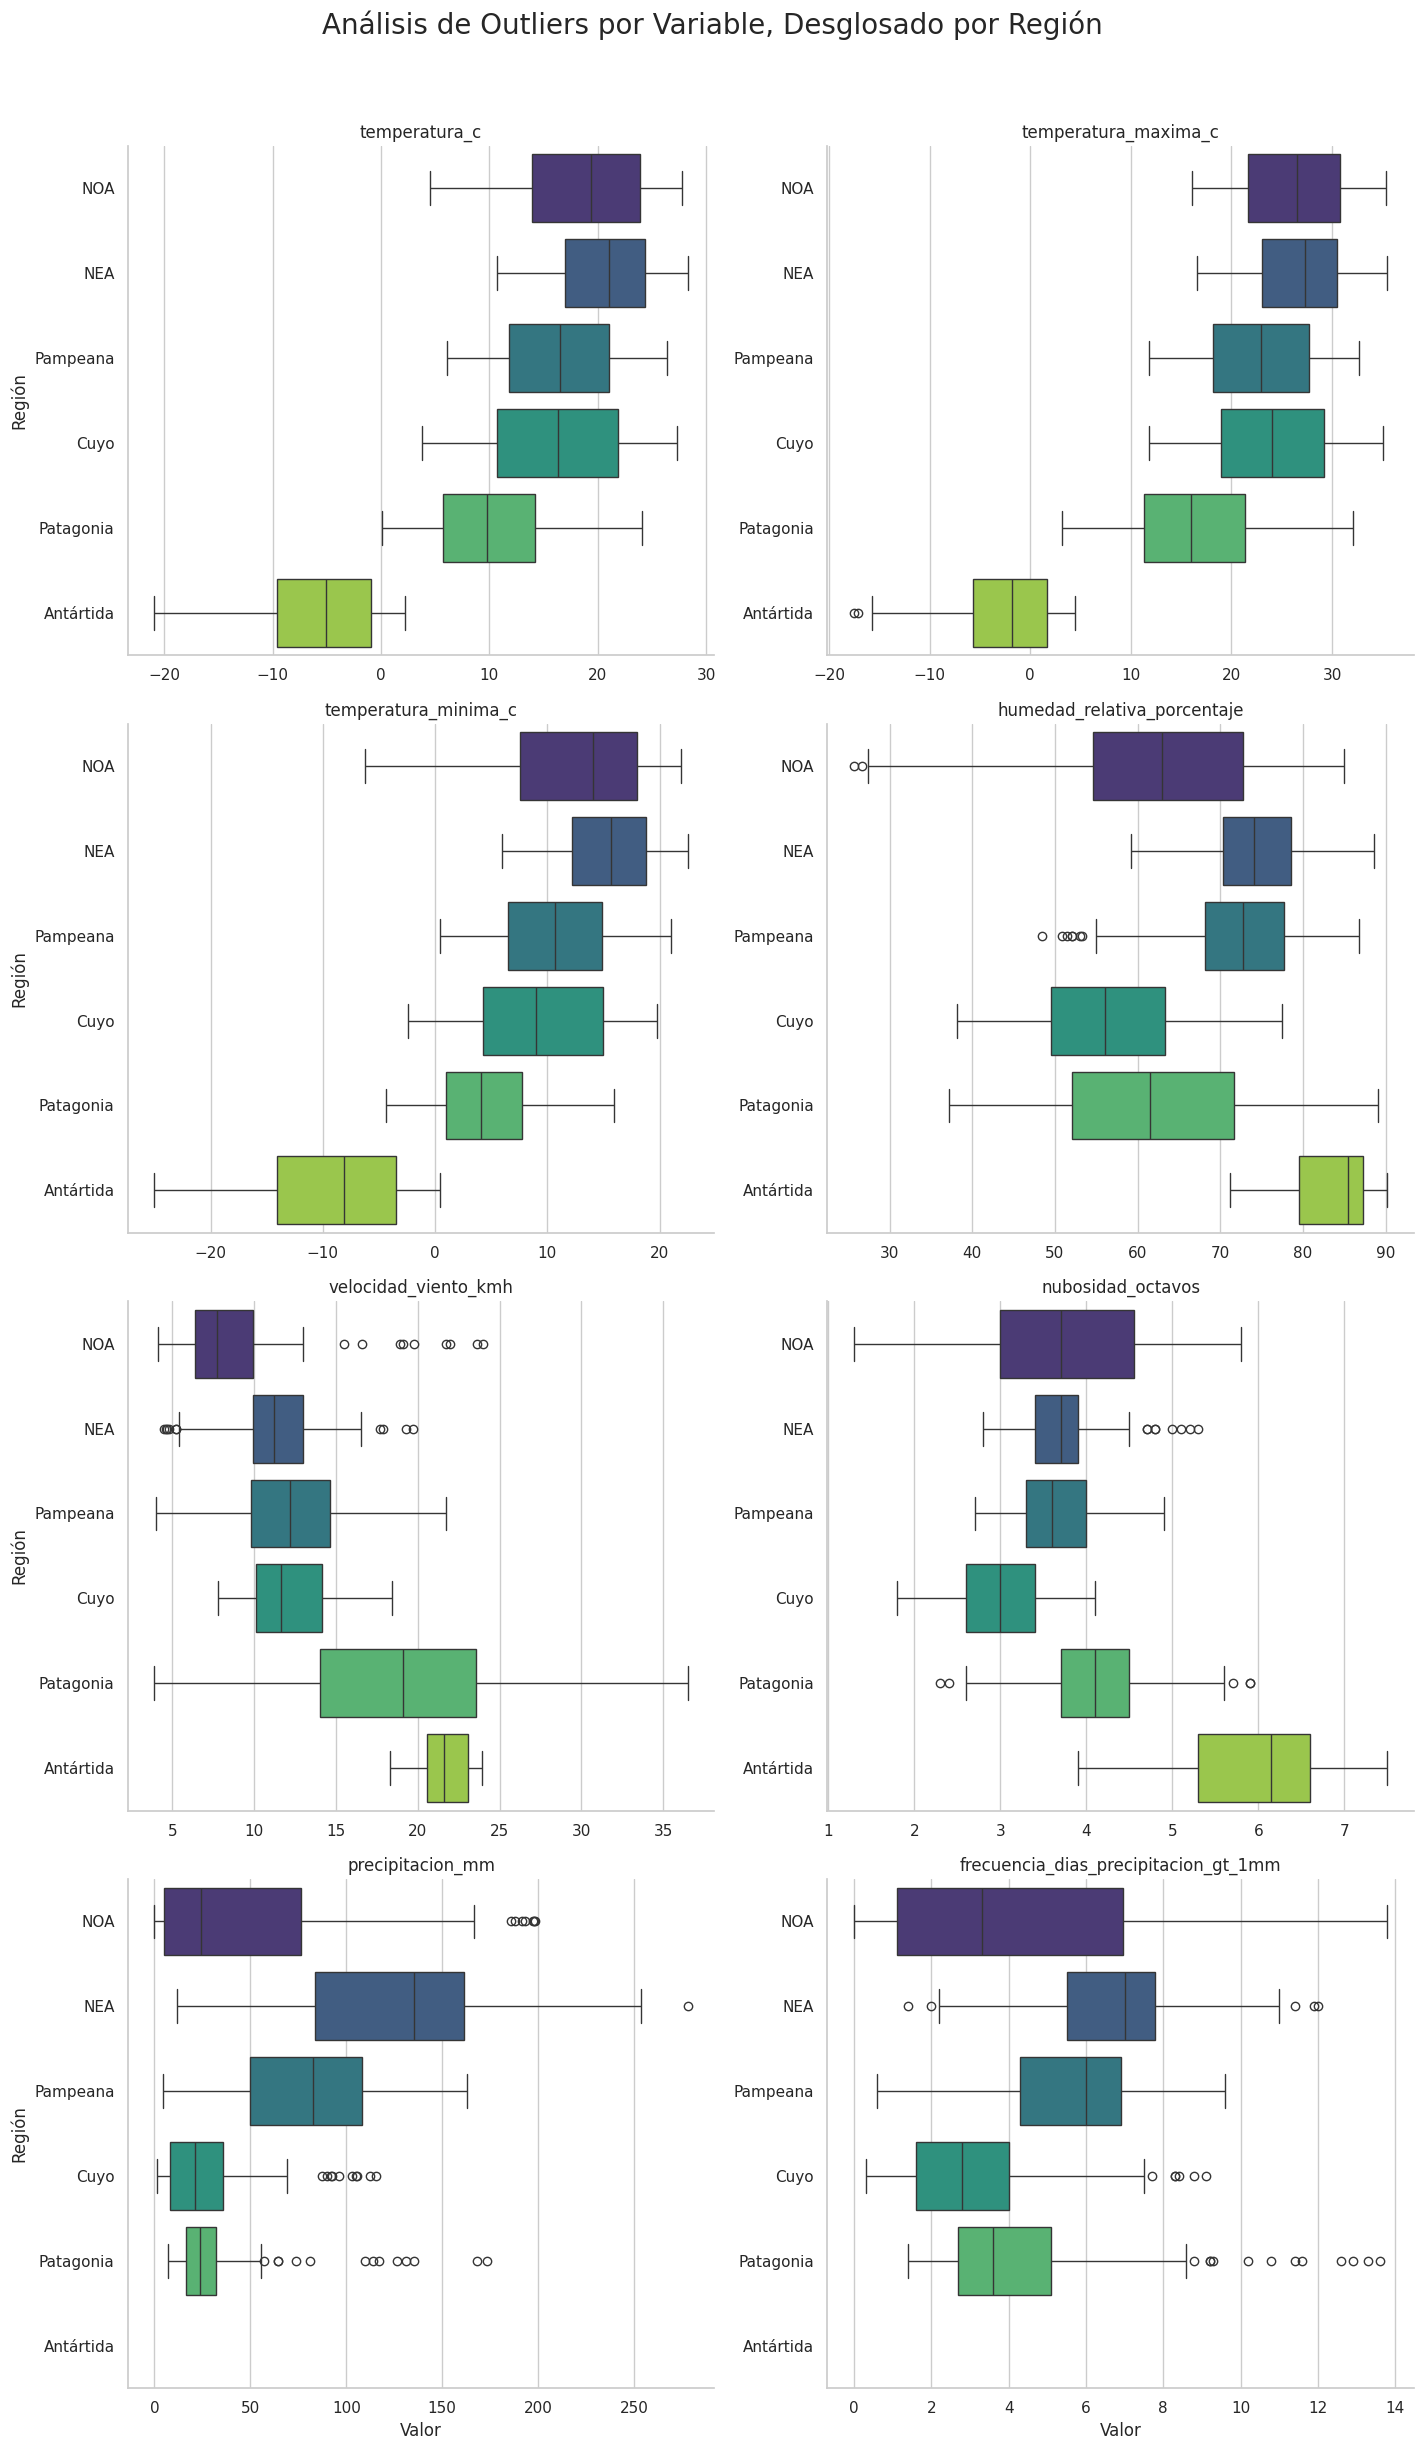

In [82]:
sns.set_theme(style="whitegrid")
regiones= df_enriquecido['region'].astype(str).unique()
print(f"\n--- Regiones encontradas: {', '.join(regiones)} ---")
g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=2,  
    sharex=False, 
    sharey=False, 
    height=6,   
    aspect=1.2
)


g.map(sns.boxplot, 'Valor', 'region', palette='viridis')
g.set_axis_labels("Valor", "Región")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable, Desglosado por Región", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [83]:
# Calculamos los límites agrupando por región Y variable
Q1_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.25)
Q3_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.75)
IQR_region = Q3_region - Q1_region

# Calculamos los límites inferior y superior
lim_inf_region = Q1_region - 1.5 * IQR_region
lim_sup_region = Q3_region + 1.5 * IQR_region 

# Creamos un DataFrame con los límites
limites_region = pd.DataFrame({'lim_inf': lim_inf_region, 'lim_sup': lim_sup_region}).reset_index()
limites_region.head()
# Unimos los límites al DataFrame original
df_con_limites_region = pd.merge(df_enriquecido, limites_region, on=['region', 'Variable'], how='left')

# Filtramos los outliers usando los límites corregidos
outliers_region = df_con_limites_region[
    (df_con_limites_region['Valor'] < df_con_limites_region['lim_inf']) | 
    (df_con_limites_region['Valor'] > df_con_limites_region['lim_sup'])
]

conteo_outliers_region = outliers_region.groupby(['region', 'Variable']).size()
total_por_region = df_enriquecido.groupby(['region', 'Variable']).size()

resumen_outliers_region = pd.DataFrame({
    'total_registros': total_por_region,
    'cantidad_outliers': conteo_outliers_region
}).fillna(0)

resumen_outliers_region['porcentaje_outliers'] = \
    (resumen_outliers_region['cantidad_outliers'] / resumen_outliers_region['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Región ---")
print(resumen_outliers_region)


--- Resumen Porcentual de Outliers por Región ---
                                                total_registros  cantidad_outliers  porcentaje_outliers
region    Variable                                                                                     
Antártida frecuencia_dias_precipitacion_gt_1mm               72                0.0             0.000000
          humedad_relativa_porcentaje                        72                0.0             0.000000
          nubosidad_octavos                                  72                0.0             0.000000
          precipitacion_mm                                   72                0.0             0.000000
          temperatura_c                                      72                0.0             0.000000
          temperatura_maxima_c                               72                2.0             2.777778
          temperatura_minima_c                               72                0.0             0.000000
          vel

## 1. Límites de Detección

A continuación, se presentan los límites calculados para cada variable:

--- Límites para detección de outliers por Variable ---

| Variable                               | lim_inf | lim_sup |
|----------------------------------------|---------|---------|
| frecuencia_dias_precipitacion_gt_1mm  | -2.7500 | 12.8500 |
| humedad_relativa_porcentaje            | 38.7125 | 99.0125 |
| nubosidad_octavos                      | 1.9500  | 5.5500  |
| precipitacion_mm                       | -101.5000 | 231.3000 |
| temperatura_c                          | -6.0500 | 37.5500 |
| temperatura_maxima_c                   | 0.7125  | 44.2125 |
| temperatura_minima_c                   | -11.4000 | 31.0000 |
| velocidad_viento_kmh                   | -0.8500 | 25.9500 |

## 2. Análisis General de Outliers por Variable

**Observaciones:**

* **`nubosidad_octavos`** presenta el mayor porcentaje de outliers (5.87%), sugiriendo variaciones considerables en la cobertura nubosa.
* Las variables de temperatura (`temperatura_maxima_c`, `temperatura_c`, `temperatura_minima_c`) también muestran una cantidad notable de outliers, indicando registros de temperaturas inusualmente altas o bajas.
* **`precipitacion_mm`** tiene el menor porcentaje de outliers (0.26%), lo cual es esperable, ya que las precipitaciones extremadamente altas son eventos menos frecuentes.

## 3. Análisis de Outliers Desglosado por Región

### Diferencias Clave en los Outliers entre Regiones:

Las regiones presentan patrones distintivos en la aparición de outliers, lo que subraya la diversidad climática del país:

* **Antártida:** Destaca por la casi total ausencia de outliers, con la excepción de `temperatura_maxima_c`. Esto sugiere una menor variabilidad en sus condiciones climáticas en comparación con otras regiones.
* **Cuyo:** Muestra una alta concentración de outliers en variables relacionadas con la precipitación (`frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`), lo que podría indicar eventos de lluvias intensas o infrecuentes. No presenta outliers en temperatura ni viento. Esto se podria explicar por las tormentas de verano tipicas de esta region.
* **NEA y NOA:** Ambas regiones del norte exhiben outliers significativos en `velocidad_viento_kmh` y `precipitacion_mm`, además de `nubosidad_octavos` en el NEA.
* **Pampeana:** Se caracteriza por tener un bajo número de outliers en general, con solo `humedad_relativa_porcentaje` mostrando una proporción notable. Esto podría indicar una mayor estabilidad en sus patrones climáticos.
* **Patagonia:** Presenta un número considerable de outliers en `frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`, lo cual es coherente con su clima variable que puede incluir eventos de precipitación extremos. También se observan outliers en `nubosidad_octavos`.

***
## Planteamiento de un problema de machine learning supervisado: predicción del potencial solar relativo

### Descripción del problema: regresión para estimar irradiancia solar

El problema se define como una tarea de **regresión**. El objetivo es entrenar un modelo de machine learning que sea capaz de predecir el valor de un **índice relativo de irradiancia solar**, que hemos denominado `GHI_Proxy`.

El modelo aprenderá la relación entre un conjunto de variables predictoras (características meteorológicas y geográficas) y esta variable objetivo construida. En esencia, el modelo no predecirá una medida física directa en kWh/m², sino un valor numérico continuo que representa el potencial solar relativo. La utilidad de este enfoque es la capacidad de **clasificar y comparar** diferentes lugares y meses según su idoneidad para la generación de energía solar.

### Definición de la variable objetivo: `GHI_Proxy`

Dado que el conjunto de datos carece de una medida directa de irradiancia solar (como la Irradiancia Global Horizontal o GHI), se ha diseñado una **variable objetivo proxy** para superar esta limitación.

### Hipótesis para la construcción de la variable objetivo

La construcción de este proxy se basa en la siguiente hipótesis física: la **amplitud térmica diurna** (la diferencia entre la temperatura máxima y mínima) es un fuerte indicador de la cantidad de energía solar que incide sobre la superficie.

* Días Despejados: Una alta radiación solar provoca un gran calentamiento durante el día y un enfriamiento significativo durante la noche, resultando en una **gran amplitud térmica**.
* Días Nublados: La cobertura de nubes bloquea la radiación solar entrante (limitando la temperatura máxima) y retiene el calor saliente (elevando la temperatura mínima), lo que conduce a una **pequeña amplitud térmica**.

La nubosidad, por lo tanto, actúa como el principal factor que atenúa la energía solar recibida.

### Formulación de la variable

Basado en esta hipótesis, la variable objetivo `GHI_Proxy` se formula de la siguiente manera:

$$GHI\_Proxy = (temperatura\_maxima\_c - temperatura\_minima\_c) \times (1 - k \times nubosidad\_octavos)$$

Donde:
* `(temperatura_maxima_degc - temperatura_minima_degc)`: Representa la **amplitud térmica**, el motor principal del proxy.
* `nubosidad_total_octavos`: Es la variable que **atenúa directamente** el efecto de la amplitud térmica.
* `k`: Es una constante de escalamiento para ajustar el impacto de la nubosidad. Se propone un valor inicial de **k = 1/8**, asumiendo una relación lineal simple.

In [85]:
# Se convierte el DataFrame largo a formato ancho
df_wide = (
    df_enriquecido
    .pivot_table(
        index=["Estación", "Mes"], 
        columns="Variable",
        values="Valor"
    )
    .reset_index()
)
df_wide.columns.name = None

df_meta = (
    df_enriquecido
    .drop_duplicates(subset=["Estación"])
    .set_index("Estación")
    [["provincia", "region", "latitud", "longitud", "altura", "oaci", "nro"]]
)

df_wide = df_wide.merge(df_meta, on="Estación", how="left")

# Se calcula la variable objetivo GHI_Proxy
k = 1 / 8  # Constante de atenuación por nubosidad

df_wide["GHI_Proxy"] = (
    (df_wide["temperatura_maxima_c"] - df_wide["temperatura_minima_c"])
    * (1 - k * df_wide["nubosidad_octavos"])
)

/tmp/ipykernel_88975/3742613665.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(


--- 1. Distribución General de GHI_Proxy ---


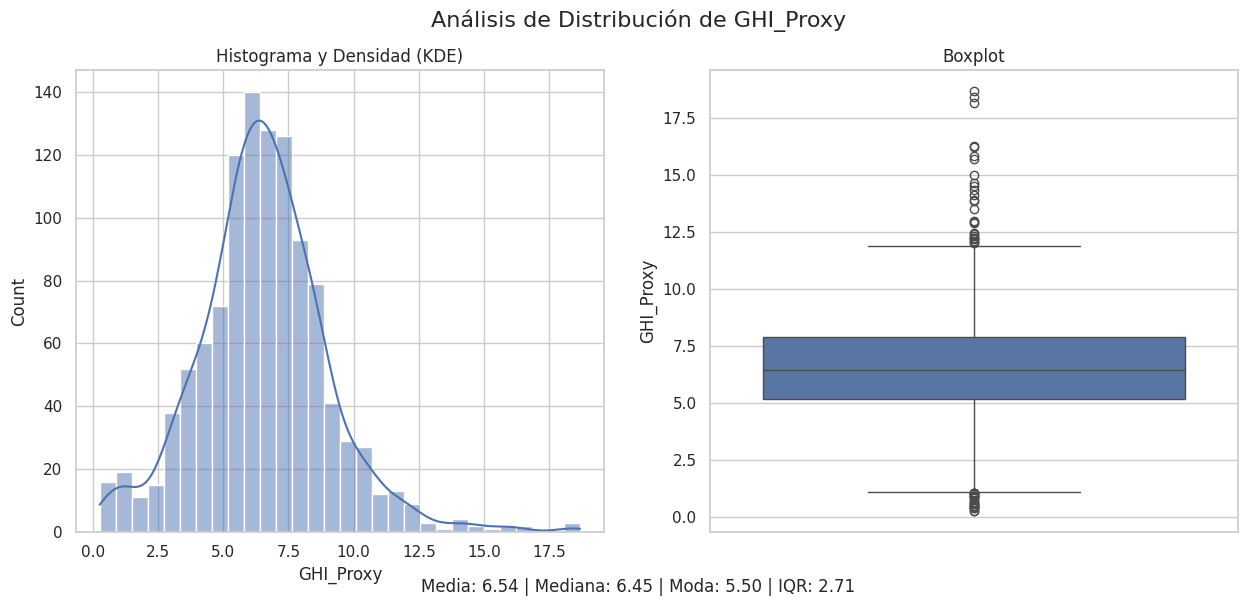



--- 2. Análisis Estadístico y Gráfico por Mes ---


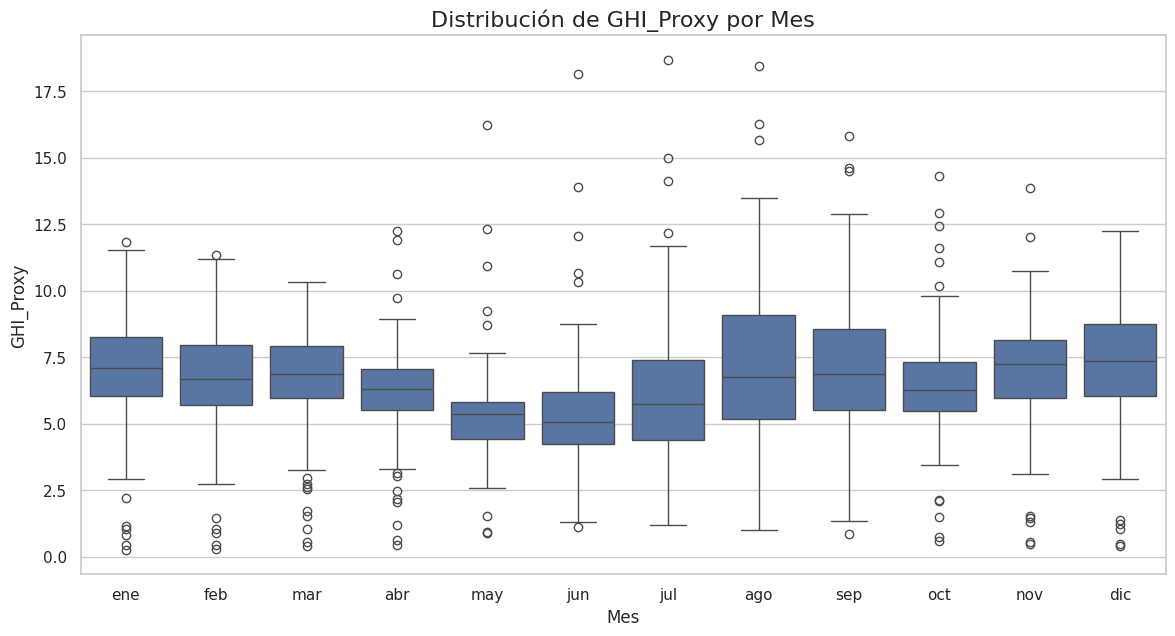



--- 3. Análisis Detallado por Región Geográfica ---


/tmp/ipykernel_88975/1507471838.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='GHI_Proxy', data=df_wide, order=median_order, palette='plasma')


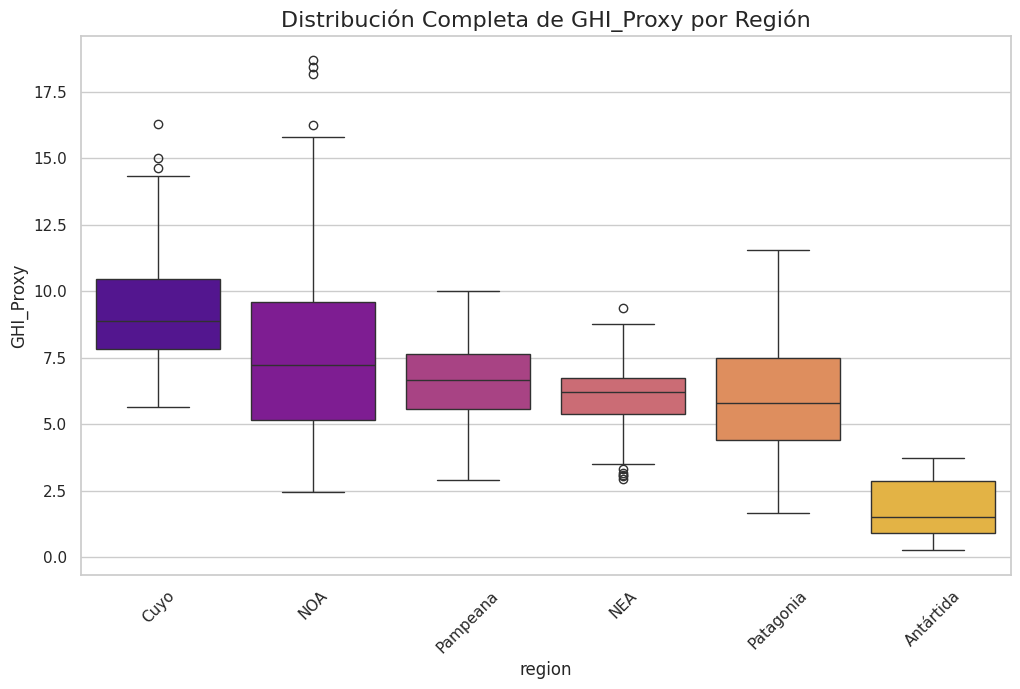



--- 4. Histogramas de GHI_Proxy para Cada Región ---


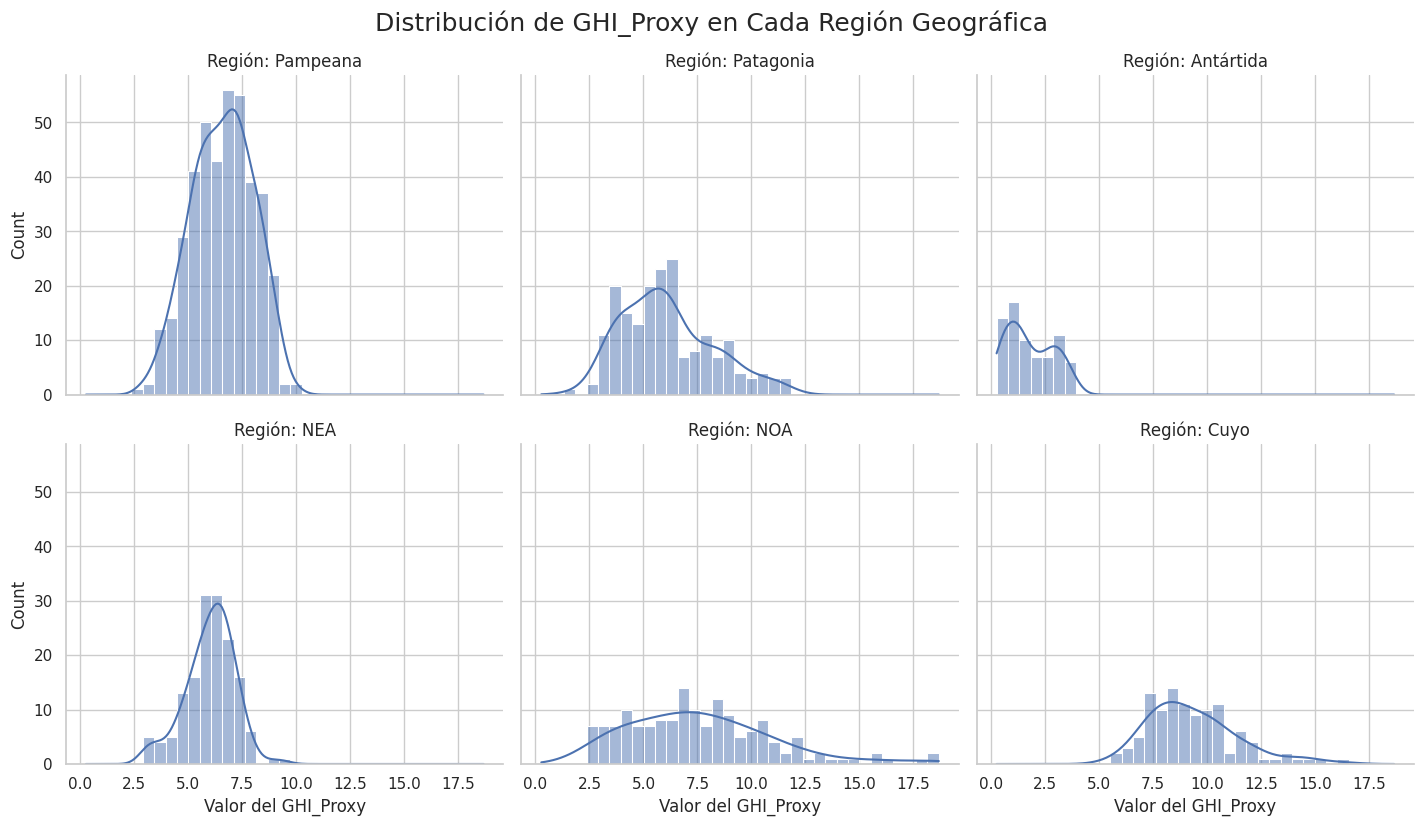

In [86]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# --- ANÁLISIS 1: VISUALIZACIÓN DE LA DISTRIBUCIÓN CON ESTADÍSTICAS ---
print("--- 1. Distribución General de GHI_Proxy ---")

# Calculamos las estadísticas
ghi_mean = df_wide['GHI_Proxy'].mean()
ghi_median = df_wide['GHI_Proxy'].median()
ghi_mode = df_wide['GHI_Proxy'].mode()[0]
ghi_iqr = iqr(df_wide['GHI_Proxy'])

# Creamos la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Análisis de Distribución de GHI_Proxy', fontsize=16)

# Histograma y Boxplot
sns.histplot(df_wide['GHI_Proxy'], kde=True, bins=30, ax=ax1)
ax1.set_title('Histograma y Densidad (KDE)')
sns.boxplot(y=df_wide['GHI_Proxy'], ax=ax2)
ax2.set_title('Boxplot')

# Añadimos el texto con las estadísticas
stats_text = f'Media: {ghi_mean:.2f} | Mediana: {ghi_median:.2f} | Moda: {ghi_mode:.2f} | IQR: {ghi_iqr:.2f}'
fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12)
plt.show()

# --- ANÁLISIS 2: COMPORTAMIENTO ESTACIONAL (POR MES) ---
print("\n\n--- 2. Análisis Estadístico y Gráfico por Mes ---")
meses_ordenados = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
df_wide['Mes'] = df_wide['Mes'].astype(CategoricalDtype(categories=meses_ordenados, ordered=True))

plt.figure(figsize=(14, 7))
sns.boxplot(x='Mes', y='GHI_Proxy', data=df_wide)
plt.title('Distribución de GHI_Proxy por Mes', fontsize=16)
plt.show()

# --- ANÁLISIS 3: POTENCIAL SOLAR POR REGIÓN ---
print("\n\n--- 3. Análisis Detallado por Región Geográfica ---")
median_order = df_wide.groupby('region')['GHI_Proxy'].median().sort_values(ascending=False).index

# Boxplot para ver la distribución completa por región
plt.figure(figsize=(12, 7))
sns.boxplot(x='region', y='GHI_Proxy', data=df_wide, order=median_order, palette='plasma')
plt.title('Distribución Completa de GHI_Proxy por Región', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# --- ANÁLISIS 4: HISTOGRAMAS POR REGIÓN ---
print("\n\n--- 4. Histogramas de GHI_Proxy para Cada Región ---")

g = sns.displot(
    data=df_wide,
    x="GHI_Proxy",
    col="region",
    col_wrap=3,  
    kde=True,
    height=4,
    aspect=1.2
)
g.fig.suptitle('Distribución de GHI_Proxy en Cada Región Geográfica', y=1.03, fontsize=18)
g.set_titles("Región: {col_name}")
g.set_xlabels("Valor del GHI_Proxy")
plt.show()

Columnas disponibles en el mapa final para GHI_Proxy: Index(['gid', 'entidad', 'fna', 'gna', 'nam', 'in1', 'fdc', 'sag', 'geometry', 'provincia_limpia', 'provincia', 'ghi_media_provincial'], dtype='object')


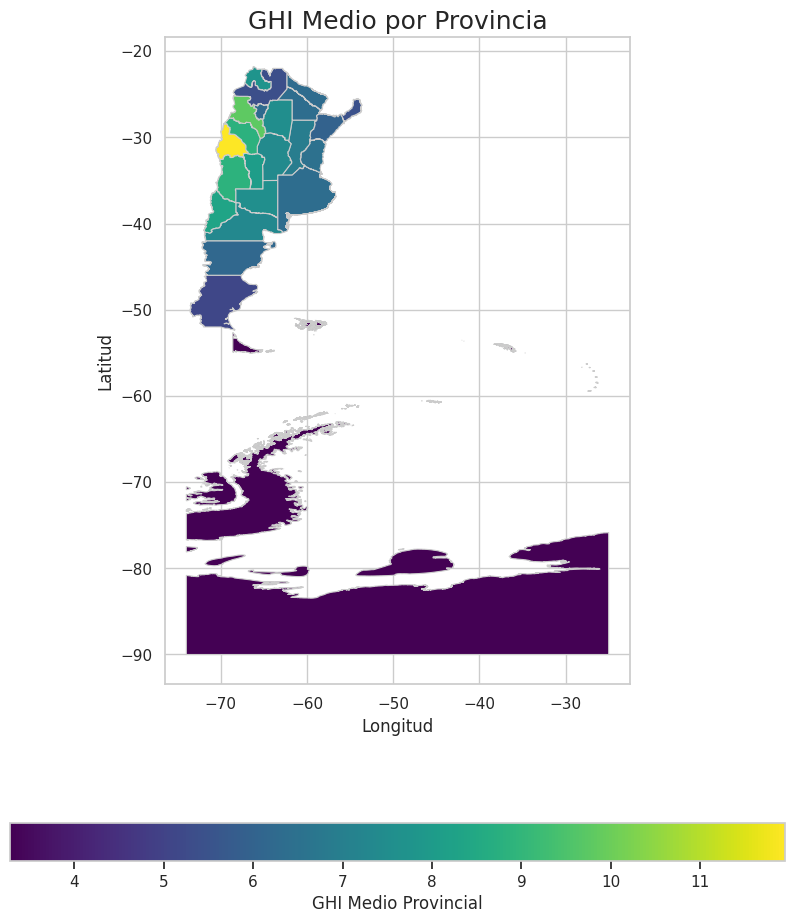

In [89]:
# --- 1. PREPARAR DATOS DE GHI_Proxy POR PROVINCIA ---

# a) Calcular la GHI_Proxy media por provincia
df_ghi_provincia = df_wide.groupby('provincia')['GHI_Proxy'].mean().reset_index()

# b) Renombrar la columna a su nombre final
df_ghi_provincia.rename(columns={'GHI_Proxy': 'ghi_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la unión
df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia_limpia'].replace(mapa_correcciones)

# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)

mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

# --- 3. UNIR LOS DATAFRAMES ---

mapa_final_ghi = pd.merge(
    mapa_provincias,
    df_ghi_provincia,
    on='provincia_limpia',
    how='left'
)

# --- 4. DIBUJAR EL MAPA ---

print("Columnas disponibles en el mapa final para GHI_Proxy:", mapa_final_ghi.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final_ghi.plot(
    column='ghi_media_provincial',
    ax=ax,
    legend=True,
    cmap='viridis', # 'viridis' or 'plasma' are good choices for GHI
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "GHI Medio Provincial", 'orientation': "horizontal"}
)

ax.set_title('GHI Medio por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

# Análisis de la distribución de GHI_Proxy

## 1. Distribución general de GHI_Proxy

* **Histograma y Densidad (KDE):** La distribución de `GHI_Proxy` muestra una forma unimodal, con una cola ligeramente asimétrica hacia valores altos. La mayor concentración de datos se encuentra alrededor de 5-8.
* **Mediana, Moda e IQR:**
    * **Mediana:** 6.54
    * **Moda:** 5.50
    * **Rango Intercuartílico (IQR):** 2.71 
* **Boxplot:** El boxplot confirma la presencia de algunos valores atípicos en ambos extremos, particularmente en los valores altos, lo cual es esperable para una medida que busca reflejar la irradiancia solar. La caja principal es relativamente compacta, lo que sugiere que la mayoría de los datos se agrupan alrededor de la mediana.

## 2. Distribución de GHI_Proxy por región geográfica

* **Pampeana:** Muestra una distribución concentrada con una alta frecuencia de valores alrededor de 6-8, lo cual indica un potencial solar consistente en esta región.
* **Patagonia:** La distribución es más dispersa y bimodal, con picos alrededor de 5 y 10. Esto podría sugerir variabilidad en las condiciones de nubosidad o la presencia de diferentes patrones climáticos dentro de la región.
* **Antártida:** Presenta valores de `GHI_Proxy` significativamente bajos y una distribución estrecha, lo cual es coherente con las condiciones de baja irradiancia solar en esa región.
* **NEA (Noreste Argentino):** Similar a la Pampeana, con una concentración de valores entre 5 y 8, aunque con una ligera cola hacia valores bajos.
* **NOA (Noroeste Argentino):** Muestra una distribución con una moda alta, lo que podría indicar un mayor potencial solar promedio, aunque también presenta una cola hacia valores bajos.
* **Cuyo:** Esta región exhibe valores de `GHI_Proxy` consistentemente altos y una distribución relativamente estrecha, lo que sugiere un alto potencial solar y menor variabilidad, en línea con su clima árido y mayor cantidad de días despejados.

## 3. Comparación completa de GHI_Proxy por región

* **Regiones con mayor potencial solar (mediana alta):**
    * **Cuyo:** Claramente se destaca con la mediana más alta y un rango intercuartílico elevado, lo que confirma su alto potencial solar.
    * **NOA:** También presenta una mediana alta, aunque con mayor dispersión que Cuyo y presencia de outliers.
* **Regiones con potencial solar moderado:**
    * **Pampeana, NEA, Patagonia:** Estas regiones muestran medianas similares y rangos intercuartílicos que se solapan, lo que indica un potencial solar intermedio y con variaciones según la región.
* **Región con menor potencial solar:**
    * **Antártida:** Confirma los valores muy bajos de `GHI_Proxy`, como se esperaba.
* **Dispersión y Outliers:** Se observa una mayor dispersión (cajas grandes) y presencia de outliers en regiones como Cuyo y NOA, lo que sugiere una mayor variabilidad en los días más o menos soleados.

## 4. Distribución de GHI_Proxy por mes


* **Variación estacional:** Se observa una clara variación estacional en el `GHI_Proxy`. Los meses de **primavera y verano** (octubre, noviembre, diciembre, enero, febrero, marzo) tienden a presentar medianas altas y una mayor dispersión, lo cual es consistente con una mayor irradiancia solar durante estas estaciones en el hemisferio sur.
* **Meses de invierno:** Los meses de **invierno** (mayo, junio, julio) muestran medianas bajas y, en algunos casos, menor dispersión, lo que refleja el menor potencial solar debido a la menor altura del sol y, potencialmente, mayor nubosidad.
* **Meses de transición:** Abril, agosto y septiembre actúan como meses de transición, con medianas que se sitúan entre los valores de invierno y verano.
* **Outliers:** La presencia de outliers en todos los meses indica que, incluso en meses con menor potencial general, pueden existir días con `GHI_Proxy` excepcionalmente altos, y viceversa.